In [1]:
# linear_interpolate
import numpy as np
from analytic_wavelet import linear_interpolate

a = 1
b = 7
t1 = 2
t2 = 4

t = np.array([t1, t2])
x = a * t + b

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = linear_interpolate(t[0], t[1], x[0], x[1], ti)
    assert(np.allclose(xi, a * ti + b))
    
a = 1 + 1j*4
b = 7 + 1j*2
x = a * t + b

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = linear_interpolate(t[0], t[1], x[0], x[1], ti)
    assert(np.allclose(xi, a * ti + b))

t0 = linear_interpolate(t[0], t[1], x[0], x[1])
x0 = linear_interpolate(t[0], t[1], x[0], x[1], t0)
assert(np.allclose(x0, 0))

print('linear_interpolate passed')

linear_interpolate passed


In [1]:
# quadratic interpolate
import numpy as np
from analytic_wavelet import quadratic_interpolate

a = 1
b = 7
c = -23

t1 = 2
t2 = 4
t3 = 8

t = np.array([t1, t2, t3])
x = a * t**2 + b * t + c

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = quadratic_interpolate(t[0], t[1], t[2], x[0], x[1], x[2], ti)
    assert(np.allclose(xi, a * ti ** 2 + b * ti + c))
    
a = 1 + 1j * 4
b = 7 + 1j * 2
c = -23 + 1j * 12
x = a * t**2 + b * t + c

for _ in range(100):
    ti = np.random.randn(1) * 10
    xi = quadratic_interpolate(t[0], t[1], t[2], x[0], x[1], x[2], ti)
    assert(np.allclose(xi, a * ti ** 2 + b * ti + c))

a = 1
b = 7
c = -23
x = a * t**2 + b * t + c
xe, te = quadratic_interpolate(t[0], t[1], t[2], x[0], x[1], x[2])

t = np.arange(-20, 20, 0.01)
x = a * t**2 + b * t + c
idx_min = np.argmin(x)
assert(np.isclose(x[idx_min], xe))
assert(np.isclose(t[idx_min], te))
print('quadratic_interpolate passed')

quadratic_interpolate passed


In [2]:
# rotate
import numpy as np
from analytic_wavelet import rotate
from analytic_wavelet.transform import _rotate_main_angle

x = np.array([np.pi/2, -np.pi/2, np.pi, -np.pi, 2*np.pi, -2*np.pi, 0])
assert(np.allclose(rotate(x), np.array([1j, -1j, -1, -1, 1, 1, 1])))
x = np.arange(-3*np.pi, 3 * np.pi, 0.1)
assert(np.allclose(np.angle(rotate(x)), _rotate_main_angle(x)))
print('rotate passed')

rotate passed


In [1]:
# GeneralizedMorseWavelet amplitude
import numpy as np
from scipy.special import dawsn, eval_hermite, binom
from analytic_wavelet import GeneralizedMorseWavelet

gamma = np.arange(2, 10)
beta = np.arange(1, 11)
gamma, beta = np.meshgrid(gamma, beta)

morse = GeneralizedMorseWavelet(gamma, beta, is_bandpass_normalized=False)

# (10, 8)
omega = morse.peak_frequency()

d_omega = 0.01
# (10, 8, num_freq_steps)
omega_grid = np.expand_dims(omega, 2) * np.reshape(np.arange(0, 20 + d_omega / 2, d_omega), (1, 1, -1))

psi = (np.expand_dims(morse.amplitude(), 2) * omega_grid ** np.expand_dims(beta, 2)
       * np.exp(-omega_grid ** np.expand_dims(gamma, 2)))

psi_integral = np.sum(psi ** 2, axis=2) * d_omega * omega / (2 * np.pi)

assert(np.allclose(psi_integral, 1, atol=1e-2))
print('amplitude passed')

amplitude passed


In [1]:
# GeneralizedMorseWavelet heisenberg_box
import numpy as np
from analytic_wavelet import GeneralizedMorseWavelet
from scipy.integrate import trapz
from scipy.fftpack import fftshift, fft

t = np.arange(-500, 501)
gamma, beta = np.meshgrid(np.arange(2, 11, 2), np.arange(2, 11, 2))
morse = GeneralizedMorseWavelet(gamma, beta)

def _sigma(y, x):
    dx = x[1] - x[0]
    x = np.reshape(x, (1,) * (len(y.shape) - 1) + (len(x),))
    y = y / np.expand_dims(trapz(y, dx=dx, axis=-1), -1)
    mu = np.expand_dims(np.real(trapz(y * x, dx=dx, axis=-1)), -1)
    return np.squeeze(np.sqrt(trapz((x - mu) ** 2 * y, dx=dx, axis=-1)), axis=-1)
    
fs = 2 * np.pi / 20
psi_a, _ = morse.make_wavelet(len(t), fs)
sigma_t = _sigma(np.abs(psi_a)**2, t)
sigma_t = sigma_t * fs

fs = 2 * np.pi / 5
psi_b, _ = morse.make_wavelet(len(t), fs)
f = 2 * np.pi * fftshift(t / len(t))
sigma_f = _sigma(np.abs(fft(psi_b))**2, f)
sigma_f = sigma_f / fs

area, box_sigma_t, box_sigma_f = morse.heisenberg_box()

assert(np.allclose(sigma_t, box_sigma_t))
assert(np.allclose(sigma_f, box_sigma_f, atol=1e-3))
print('heisenberg_box passed')

heisenberg_box passed


In [1]:
# GeneralizedMorseWavelet moments
import numpy as np
from analytic_wavelet import GeneralizedMorseWavelet
import scipy.special

# energy cumulant
morse = GeneralizedMorseWavelet(gamma=np.array([3, 0.5, 9]), beta=np.array([2.0, 15.12, 0.751]))
omega = morse.peak_frequency()
_, _, sigma_f = morse.heisenberg_box()
moments, cumulants = morse.energy_cumulants(2)
assert(np.allclose(np.sqrt(cumulants[2] / omega ** 2), sigma_f))

# frequency moments
gamma, beta = np.meshgrid(np.arange(2, 10.05, .1), np.arange(1, 10.05, .1))
moments, cumulants = GeneralizedMorseWavelet(gamma=gamma, beta=beta).frequency_domain_cumulants(10)
for p in range(1, 11):
    frequency_moment = (2 * ((np.exp(1) * gamma) / beta) ** (beta / gamma) 
                        * (1 / (2 * np.pi * gamma)) * scipy.special.gamma((beta + 1 + p) / gamma))
    assert(np.allclose(moments[p], frequency_moment))

# numerical
gamma, beta = np.meshgrid(np.arange(2, 13, 2), np.arange(1, 11, 2))
omi = np.arange(0, 20.005, .01)
d_omi = omi[1] - omi[0]
omi = np.reshape(omi, (1, 1, -1))
morse = GeneralizedMorseWavelet(gamma, beta)
peak_frequency = np.expand_dims(morse.peak_frequency(), 2)
psi = (
    np.expand_dims(morse.amplitude(), 2) 
    * (peak_frequency * omi) ** np.expand_dims(beta, 2) 
    * np.exp(-(peak_frequency * omi) ** np.expand_dims(gamma, 2)))
peak_frequency = np.squeeze(peak_frequency, axis=2)
freq_1 = d_omi / (2 * np.pi) * peak_frequency ** 2 * np.sum(omi * psi, axis=2)
energy_1 = d_omi / (2 * np.pi) * peak_frequency ** 2 * np.sum(omi * psi ** 2, axis=2)
freq_2 = d_omi / (2 * np.pi) * peak_frequency ** 3 * np.sum(omi**2 * psi, axis=2)
energy_2 = d_omi / (2 * np.pi) * peak_frequency ** 3 * np.sum(omi**2 * psi ** 2, axis=2)

frequency_moments, _ = morse.frequency_domain_cumulants(2)
energy_moments, _ = morse.energy_cumulants(2)

assert(np.allclose(freq_1, frequency_moments[1]))
assert(np.allclose(energy_1, energy_moments[1]))
assert(np.allclose(freq_2, frequency_moments[2]))
assert(np.allclose(energy_2, energy_moments[2]))

# cumulants
gamma, beta = np.meshgrid(np.arange(2, 13, 2), np.arange(1, 11, 2))
moments, cumulants = GeneralizedMorseWavelet(gamma, beta).frequency_domain_cumulants(3)
assert(np.allclose(cumulants[0], np.log(moments[0])))
assert(np.allclose(cumulants[1], moments[1] / moments[0]))
assert(np.allclose(cumulants[2], moments[2] / moments[0] - (moments[1] / moments[0]) ** 2))
assert(np.allclose(
    cumulants[3], 
    2 * (moments[1] ** 3 / moments[0] ** 3) 
    - 3 * moments[1] / moments[0] * moments[2] / moments[0] + moments[3] / moments[0]))

# alternate
moments, cumulants = GeneralizedMorseWavelet(gamma, beta).energy_cumulants(3)
a = GeneralizedMorseWavelet(gamma, beta).amplitude()
for order in range(4):
    assert(np.allclose(
        moments[order], 
        ((a ** 2) / (2 ** ((2 * beta + 1 + order) / gamma))) 
        * (1 / (2 * np.pi * gamma)) * scipy.special.gamma((2 * beta + 1 + order) / gamma)))

assert(np.allclose(
    cumulants[3], 
    ((moments[3] / moments[0]) 
     - 3 * ((moments[1] * moments[2]) / (moments[0] ** 2)) 
     + 2 * ((moments[1] ** 3) / (moments[0] ** 3)))))

# ratio
gamma, beta = np.meshgrid(np.arange(2, 12.25, 0.5), np.arange(1, 10.25, 0.5))
moments, cumulants = GeneralizedMorseWavelet(gamma, beta).energy_cumulants(2)
expected = np.exp(
    scipy.special.gammaln((2 * beta + 3) / gamma) 
    + scipy.special.gammaln((2 * beta + 1) / gamma) 
    - 2 * scipy.special.gammaln((2 * beta + 2) / gamma)) - 1
actual = (moments[2] / moments[0]) / np.square(moments[1] / moments[0]) - 1 
assert(np.allclose(expected, actual))

print('moments passed')

moments passed


In [1]:
# GeneralizedMorseWavelet make_wavelet
import numpy as np
import scipy.special
from scipy.special import dawsn, binom
from scipy.fftpack import fft
from analytic_wavelet import GeneralizedMorseWavelet

def scorer(z, n):
    # Orig comment:
    # This is not a very good way to compute the Scorer functions.
    # Need to set n really high to have to integral behave nicely.
    # Only used for testing purposes.
    z = np.reshape(z, (-1, 1))
    u = np.linspace(0, 10, n)
    du = u[1] - u[0]
    
    return (1 / np.pi) * du * np.sum(
        np.exp(-(np.tile(np.expand_dims(u, axis=0), (z.shape[0], 1)) ** 3 / 3) + (z * np.conj(u))), axis=1)


def hermite_polynomial(n, x):
    if n < 0:
        raise ValueError('n must be >= 0')
    result = np.zeros((n + 1,) + x.shape, x.dtype)
    result[0] = np.ones_like(x)
    if n == 0:
        return result
    result[1] = 2 * x
    if n == 1:
        return result
    for i in range(3, n + 1 + 1):
        result[i - 1] = 2 * x * result[i - 2] - 2 * (i - 2) * result[i - 3]
    return result


# test hermite_polynomial
t = np.arange(-2, 2.005, .01)
h = hermite_polynomial(4, t)
assert(np.allclose(h[0], np.ones_like(t)))
assert(np.allclose(h[1], 2 * t))
assert(np.allclose(h[2], 4 * t ** 2 - 2))
assert(np.allclose(h[3], 8 * t ** 3 - 12 * t))
assert(np.allclose(h[4], 16 * t ** 4 - 48 * t ** 2 + 12))


def dawsn_deriv(n, x):
    y = np.zeros_like(x)
    # z = [eval_hermite(i, x) for i in range(n + 1)]
    # jz = [eval_hermite(i, 1j * x) for i in range(n + 1)]
    z = hermite_polynomial(n, x)
    jz = hermite_polynomial(n, 1j * x)
    for k in range(1, n + 1):
        y = y + binom(n, k) * z[n - k] * ((1j ** (k - 1)) * jz[k - 1])
    return ((-1) ** n) * (z[n] * dawsn(x) - y)


# test dawsn_deriv
dt = 0.01
t = np.arange(-15, 15.005, dt)
dk1 = dawsn(t)
# avoid differentiation errors at edges
dk1[0] = np.nan   
dk1[-1] = np.nan

for k in range(1, 6):
    dk2 = dawsn_deriv(k, t)
    dk1 = np.gradient(dk1, dt, axis=-1)
    dk1[0] = np.nan
    dk1[-1] = np.nan
    err = np.nansum(np.abs(dk1 - dk2) ** 2) / np.nansum(np.abs(dk1) ** 2)
    assert(err < 1e-3)
    

# check energy == 1
psi, _ = GeneralizedMorseWavelet(gamma=2, beta=4, is_bandpass_normalized=False).make_wavelet(
    num_timepoints=1023, scale_frequencies=2*np.pi/np.logspace(np.log10(5),np.log10(40)), num_orthogonal_family_members=2)
assert(np.allclose(np.sum(np.abs(psi)**2, axis=-1), 1, atol=1e-4))


# check centering (odd num_timepoints)
psi, _ = GeneralizedMorseWavelet(gamma=2, beta=4).make_wavelet(
    num_timepoints=1023, scale_frequencies=2*np.pi/np.logspace(np.log10(5),np.log10(40)))
assert(np.all(np.max(np.abs(psi), axis=-1) == np.abs(psi[..., 1024//2 - 1])))


# check centering (even num_timepoints)
psi, _ = GeneralizedMorseWavelet(gamma=2, beta=4).make_wavelet(
    num_timepoints=1024, scale_frequencies=2*np.pi/np.logspace(np.log10(5),np.log10(40)))
assert(np.all(np.logical_or(
    np.max(np.abs(psi), axis=-1) == np.abs(psi[..., 1024//2-1]),
    np.max(np.abs(psi), axis=-1) == np.abs(psi[..., 1024//2]))))


# test scorer? Not sure what this is doing
t = np.arange(-50, 51, 1)
psi_1, _ = GeneralizedMorseWavelet(gamma=3, beta=0).make_wavelet(
    len(t), GeneralizedMorseWavelet(gamma=3, beta=1).peak_frequency())
c = 3 ** (1 / 3)
psi_2 = (1 / c) * scorer(1j * t / c, 1000)
err = np.sum(np.abs(psi_1 - np.expand_dims(psi_2, 0)) ** 2, axis=1) / np.sum(np.abs(psi_1) ** 2, axis=1)
assert(err < 1e-1)


# test cauchy
dt = .01
t = np.arange(-25, 25.005, dt)
psi_1, _ = GeneralizedMorseWavelet(gamma=1, beta=0).make_wavelet(
    len(t), GeneralizedMorseWavelet(gamma=1, beta=1).peak_frequency() * dt)
psi_1 /= dt
psi_2 = (1 / np.pi) * (1 / (1 - 1j * t))
err = np.sum(np.abs(psi_1 - psi_2) ** 2, axis=1) / np.sum(np.abs(psi_1) ** 2, axis=1)
assert(err < 1e-1)


# test gaussian
dt = 0.1
t = np.arange(-50, 50.05, dt)
psi_1, _ = GeneralizedMorseWavelet(gamma=2, beta=0).make_wavelet(
    len(t), GeneralizedMorseWavelet(gamma=2, beta=1).peak_frequency() * dt)
psi_1 /= dt
psi_2 = (1 / (2 * np.sqrt(np.pi))) * (np.exp(-(t / 2) ** 2) + 1j * dawsn(t / 2) * (2 / np.sqrt(np.pi)))
err = np.sum(np.abs(psi_1 - psi_2) ** 2, axis=1) / np.sum(np.abs(psi_1) ** 2, axis=1)
assert(err < 1e-1)


# test dawson
dt = 0.01
t = np.arange(-15, 15.005, dt)
order = 5
herm = hermite_polynomial(order + 1, t / 2)
herm = herm[1:]

g = np.exp(-(t ** 2 / 4))
for k in range(1, order + 1):
    d = dawsn_deriv(k, t / 2)
    coeff = (1 / (4 * np.sqrt(np.pi))) * GeneralizedMorseWavelet(gamma=2, beta=k).amplitude() * (1j / 2) ** k
    psi_1_temp, _ = GeneralizedMorseWavelet(gamma=2, beta=k).make_wavelet(
        len(t), GeneralizedMorseWavelet(gamma=2, beta=k).peak_frequency() * dt)
    psi_1 = psi_1_temp[0] / dt
    psi_2 = coeff * (g * herm[k - 1] + 1j * (-1) ** k * d * (2 / np.sqrt(np.pi)))
    err = np.sum(np.abs(psi_1 - psi_2) ** 2) / np.sum(np.abs(psi_1) ** 2)
    assert(err < 1e-3)


# admissability
gamma, beta = np.meshgrid(np.arange(1, 12), np.arange(1, 11))
gamma = np.reshape(gamma, -1)
beta = np.reshape(beta, -1)
num_timepoints = 1000
omega = np.arange(0, 1, 1 / num_timepoints)
omega[0] = 1e-4
dt = 1 / 10
for g, b in zip(gamma, beta):
    morse = GeneralizedMorseWavelet(g, b)
    _, psi = morse.make_wavelet(num_timepoints, morse.peak_frequency() * dt)
    psi = psi ** 2 / omega
    c_psi_1 = np.sum(psi, axis=1) / num_timepoints
    c_psi_2 = morse.amplitude() ** 2 * (1 / (g * 2 ** (2 * b / g))) * scipy.special.gamma((2 * b) / g)
    assert(np.allclose(c_psi_1, c_psi_2, atol=1e-2))

    
# fft
fs = 1 / np.logspace(np.log10(5), np.log10(40)) 
num_timepoints = 1023
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(num_timepoints, fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(num_timepoints + 1, fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))
psi, psi_f = GeneralizedMorseWavelet(1, 4).make_wavelet(num_timepoints, -fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(num_timepoints + 1, -fs, 2)
assert(np.allclose(np.abs(fft(psi)), np.abs(psi_f)))

print('make_wavelets passed')

make_wavelets passed


C:\Users\danrs\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in true_divide
C:\Users\danrs\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in greater_equal


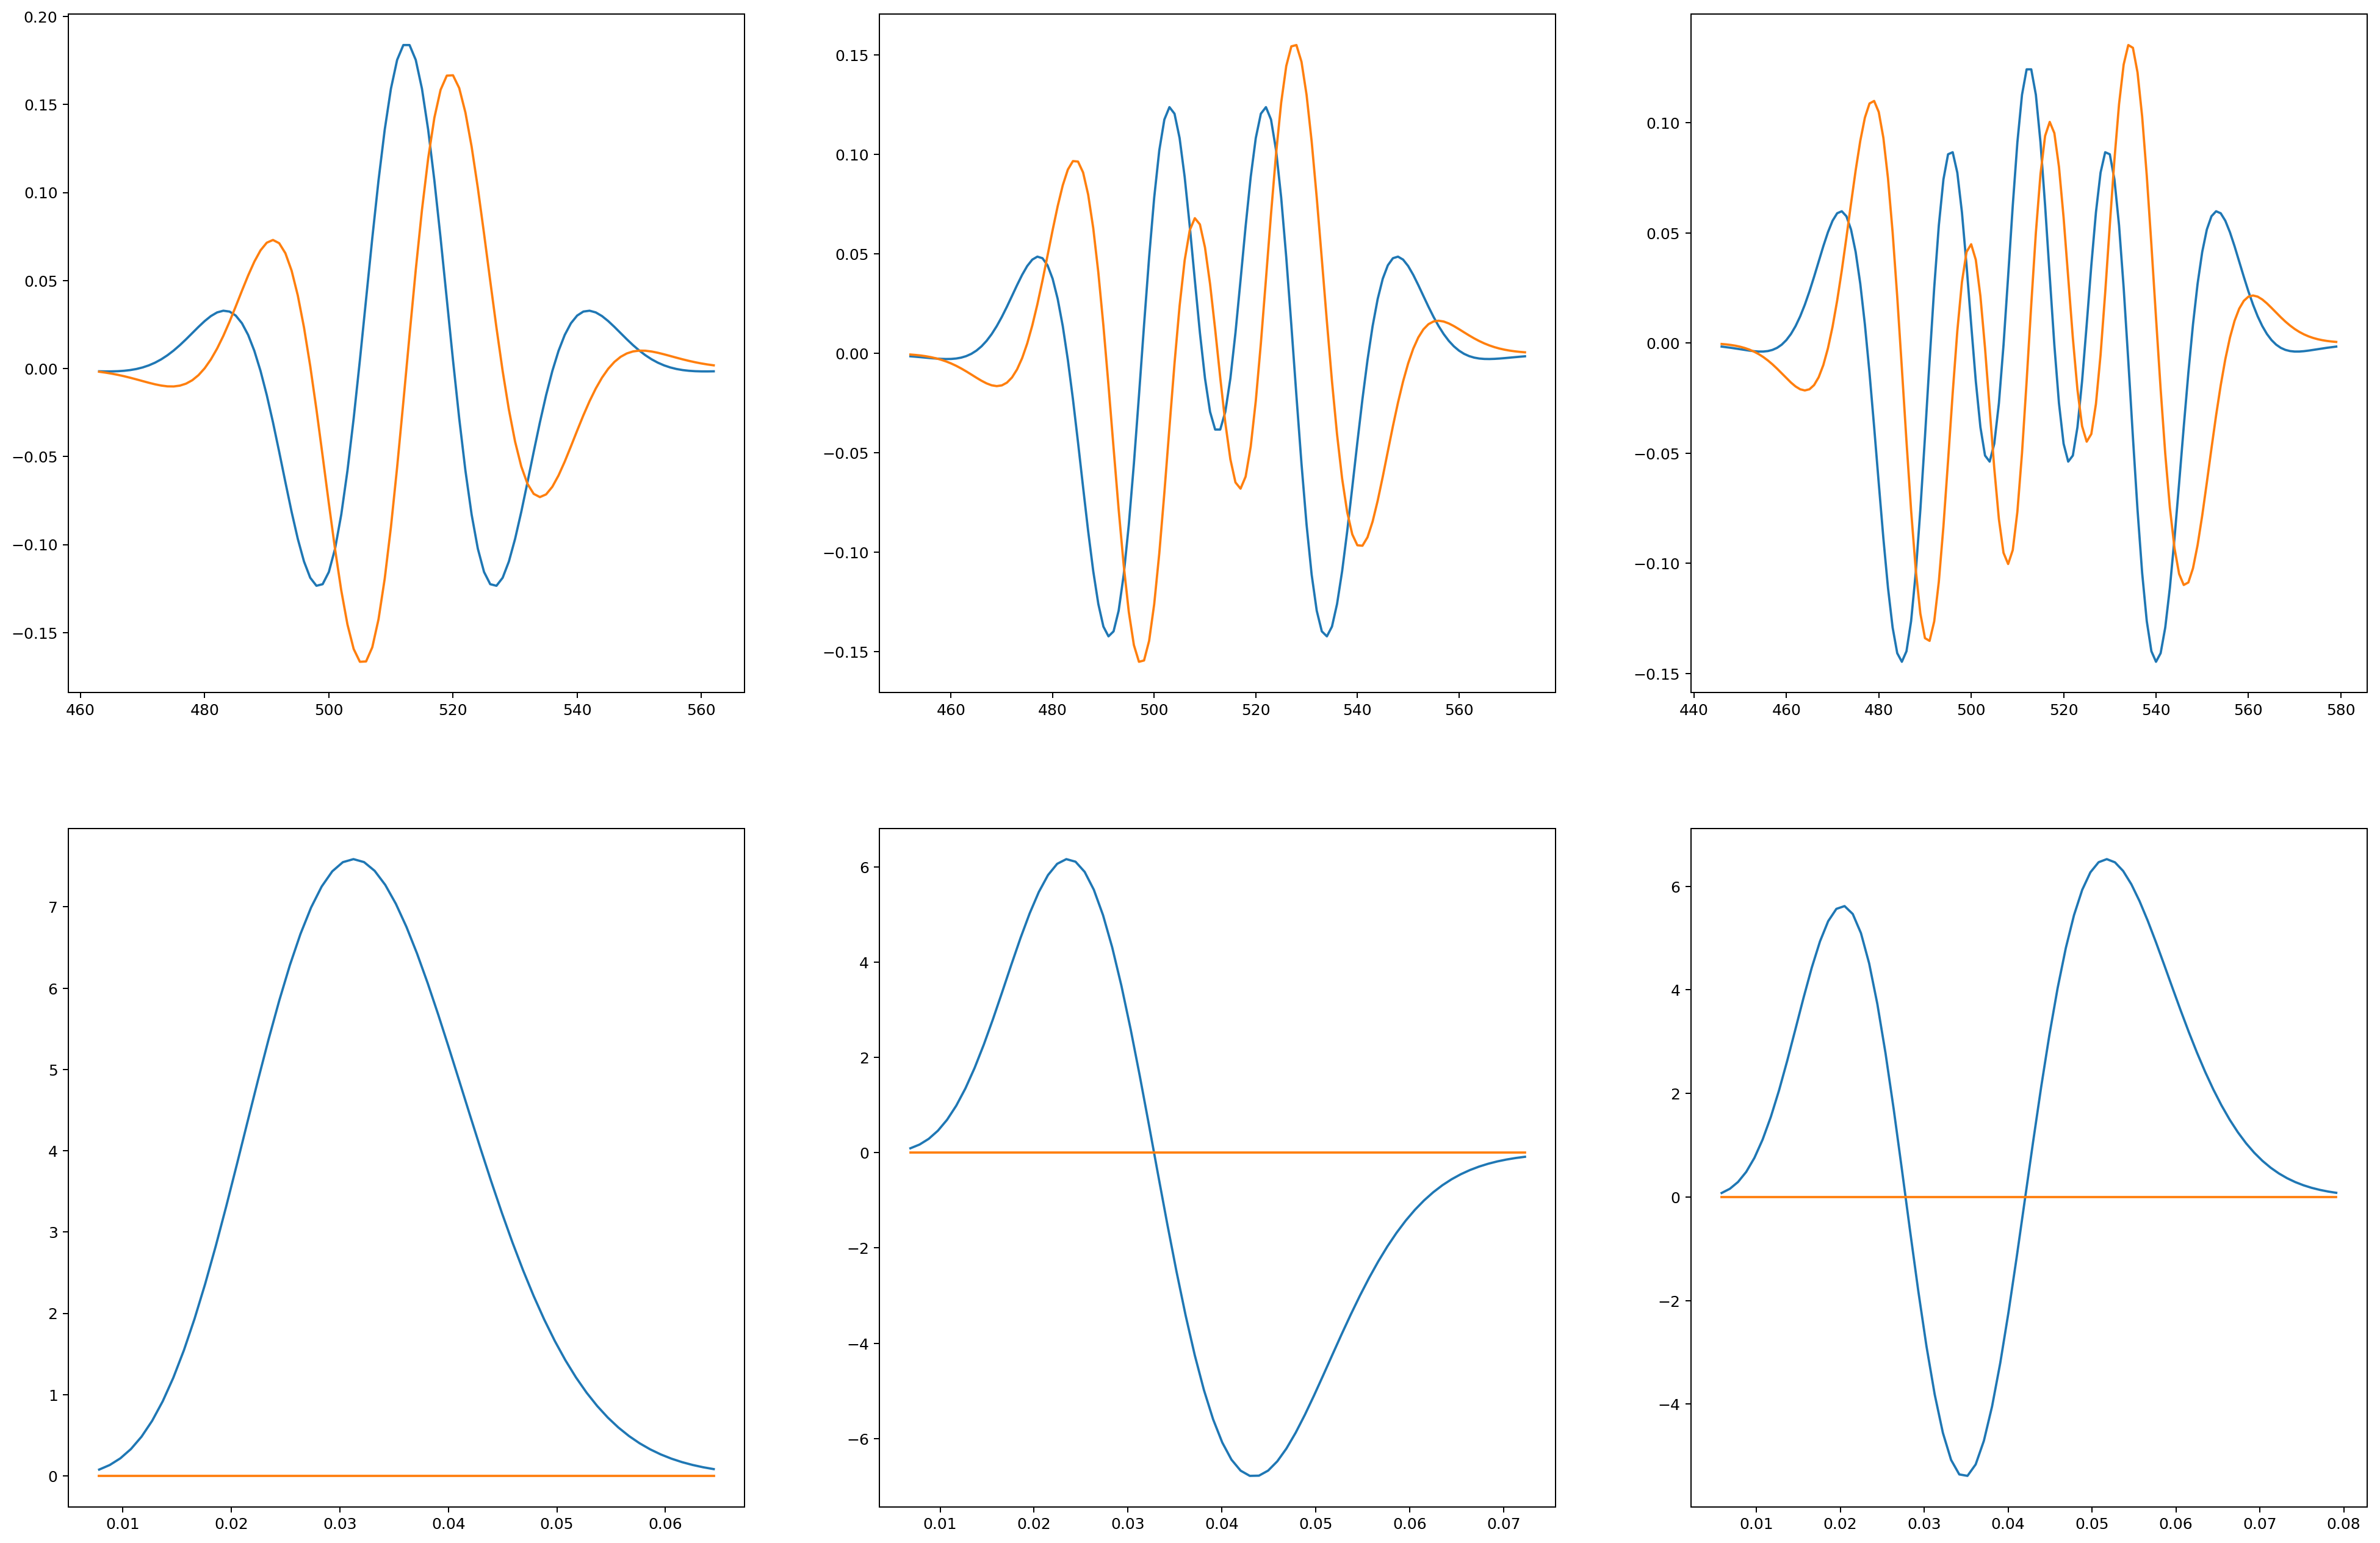

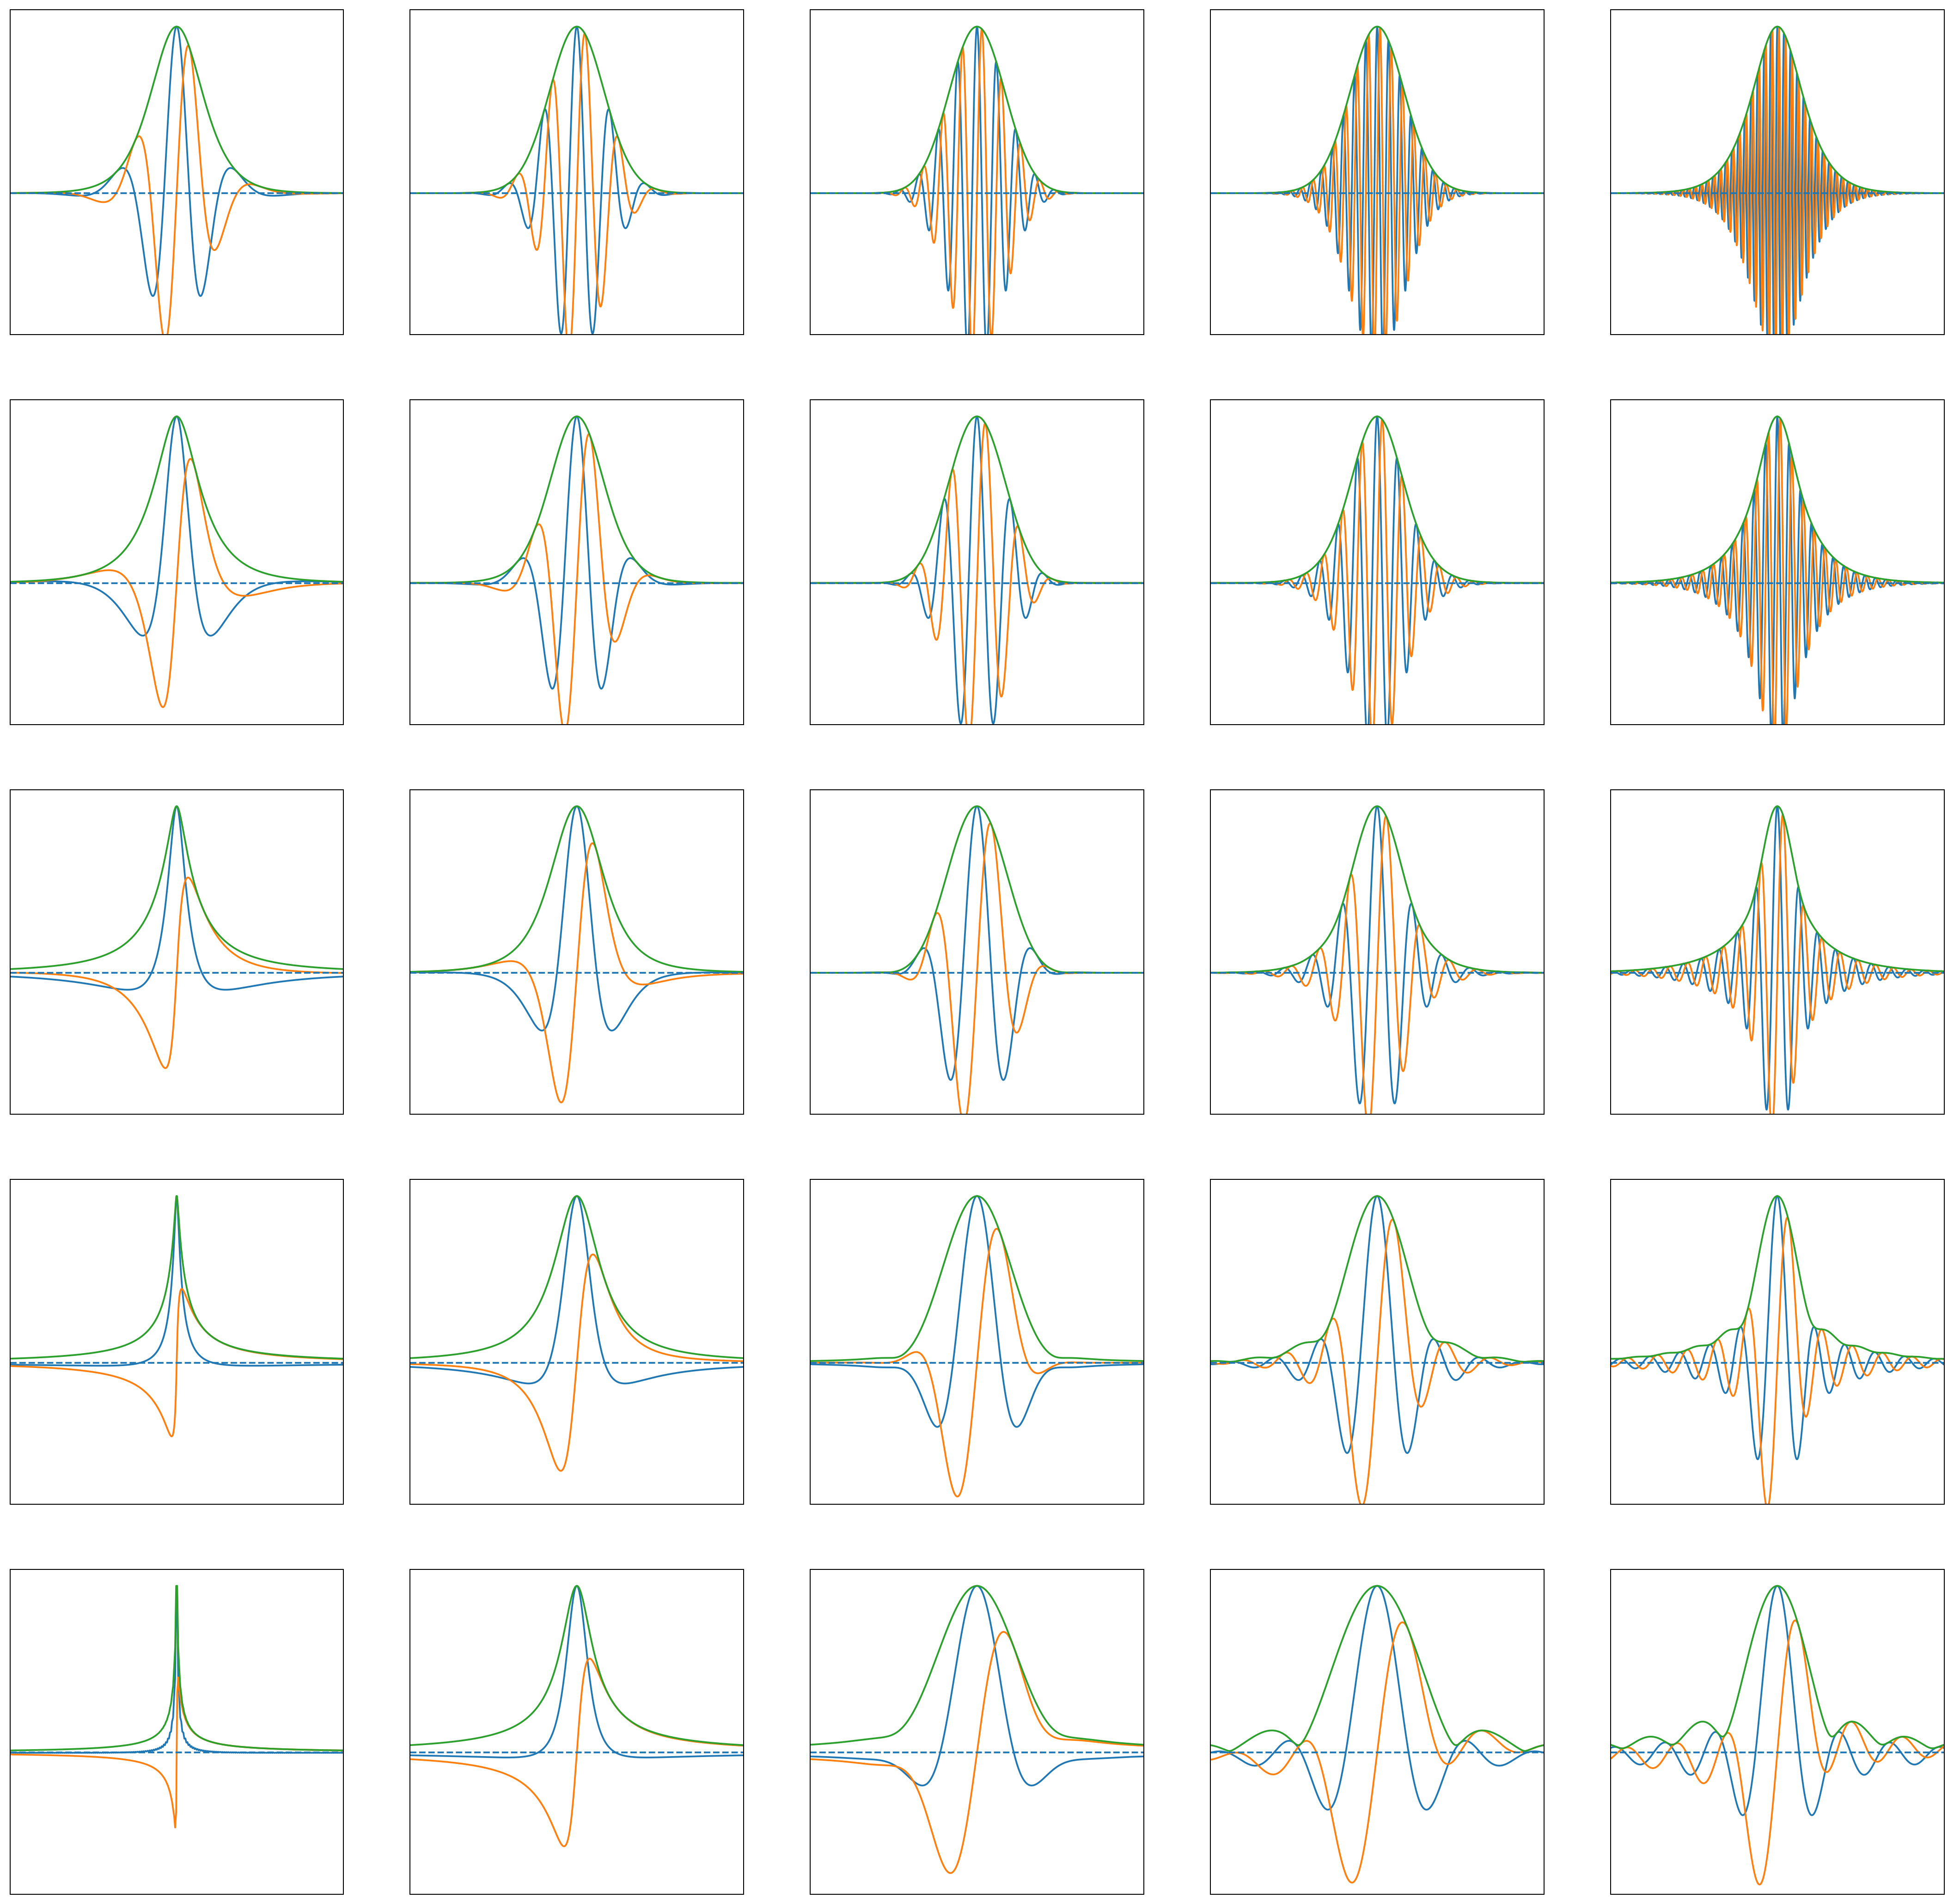

In [1]:
# GeneralizedMorseWavelet make_wavelet figures
import numpy as np
from analytic_wavelet import GeneralizedMorseWavelet
%matplotlib inline
from matplotlib import pyplot as plt, gridspec
from scipy.fftpack import fftshift

num_timepoints = 256 * 4
fs = 2 * np.pi / 8 / 4
psi, psi_f = GeneralizedMorseWavelet(gamma=2, beta=5, is_bandpass_normalized=False).make_wavelet(
    num_timepoints=num_timepoints, scale_frequencies=fs, num_orthogonal_family_members=3)
# psi_f = fftshift(psi_f)

def uv_plot(ax, x, y):
    u = np.real(y)
    v = np.imag(y)
    a = np.abs(y)
    rel_u = np.abs(u) / np.max(np.abs(u))
    rel_v = np.abs(v) / np.max(np.abs(v))
    indices_plot = np.flatnonzero(np.logical_or(rel_u >= 0.01, rel_v >= 0.01))
    start, stop = np.min(indices_plot), np.max(indices_plot) + 1
    ax.plot(x[start:stop], u[start:stop])
    ax.plot(x[start:stop], v[start:stop])
    # ax.plot(x[start:stop], a[start:stop])

t = np.arange(1, num_timepoints + 1)
# t = t - np.mean(t)
# t = t * fs
# t = t / (GeneralizedMorseWavelet(2, 5).time_domain_width() / np.pi)
# indices_plot = np.nonzero(np.logical_and(t >= -3, t <= 3))
# start, stop = np.min(indices_plot), np.max(indices_plot) + 1
f = np.arange(0, 1, 1 / num_timepoints)

fig = plt.figure(figsize=(27, 18), dpi=180)
grid = gridspec.GridSpec(2, 3)

for i in range(6):
    row, col = divmod(i, 3)
    ax = fig.add_subplot(grid[row, col])
    x = t if row == 0 else f
    y = psi if row == 0 else psi_f
    y = y[col, 0]
    uv_plot(ax, x, y)

plt.show()
    
fig = plt.figure(figsize=(30, 30), dpi=180)
grid = gridspec.GridSpec(5, 5)
num_timepoints = 2 ** 16
fs = 1 / 512
t = np.arange(1, num_timepoints + 1)
t = t - np.mean(t)
t = t * fs
gamma_beta = [1/3, 1, 3, 9, 27]
for i, b in enumerate(reversed(gamma_beta)):
    for j, g in enumerate(gamma_beta):
        morse = GeneralizedMorseWavelet(g, b)
        p = morse.time_domain_width()        
        psi, _ = morse.make_wavelet(num_timepoints, 2 * np.pi * fs)
        ax = fig.add_subplot(grid[i, j])
        x = np.concatenate([np.real(psi), np.imag(psi), np.abs(psi)], axis=0).T / np.max(np.abs(psi))
        ax.plot(t / (p / np.pi), x)
        ax.axhline(0, linestyle='--')
        ax.set_xlim(-3, 3)
        ax.set_ylim(-0.85, 1.1)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

In [1]:
# GeneralizedMorseWavelet log_spaced_frequencies
import numpy as np
from analytic_wavelet import GeneralizedMorseWavelet

# test high frequency
morse = GeneralizedMorseWavelet(3, 4)
nyquist_overlap = 0.1
fs = morse.log_spaced_frequencies(low=0.1, nyquist_overlap=nyquist_overlap)
_, psi_f = morse.make_wavelet(num_timepoints=10000, scale_frequencies=np.max(fs))
assert(np.isclose(psi_f[0, psi_f.shape[1] // 2 - 1] / 2, nyquist_overlap, atol=1e-3))

# test low frequency
num_timepoints = 1001
gamma, beta = np.meshgrid(np.arange(1/3, 11, 1), np.arange(1, 11, 1))
gamma = np.reshape(gamma, -1)
beta = np.reshape(beta, -1)

for g, b in zip(gamma, beta):
    morse = GeneralizedMorseWavelet(g, b, is_bandpass_normalized=False)
    fs = morse.log_spaced_frequencies(num_timepoints=num_timepoints / 10, high=np.pi, nyquist_overlap=0.95, endpoint_overlap=0.5)
    psi, _ = morse.make_wavelet(num_timepoints, np.min(fs))
    indices = np.arange(psi.shape[-1] // 2 - 50, psi.shape[-1] // 2 + 51)
    # had to increase the tolerance here ... not sure if this is working right
    assert(np.isclose(np.sum(np.square(np.abs(psi[0, indices]))), 0.95, atol=0.03))
# figure,plot(sum(squared(psi((end+1)/2-50:(end+1)/2+50,:)),1))
# bool=aresame(median(sum(squared(psi((end+1)/2-50:(end+1)/2+50,:)))),0.95,0.01);

print('log_spaced_frequencies passed -- with increased tolerance')


log_spaced_frequencies passed -- with increased tolerance


In [1]:
# analytic_transform
import numpy as np
from scipy.signal import detrend
from analytic_wavelet import analytic_transform, unpad, load_test_data


# test analytic_transform
solomon = load_test_data('test_data/solomon.mat')
x = np.concatenate([solomon['x'], solomon['y'], solomon['z']], axis=1).T
x = detrend(x, axis=-1)
pad_width = ((0, 0), (x.shape[-1], x.shape[-1]))
z = unpad(pad_width, analytic_transform(np.pad(x, pad_width, 'wrap')))
assert(np.all(np.sum(np.abs(np.real(z) - x) ** 2, axis=-1) / np.sum(np.abs(z) ** 2, axis=-1) < 1e-3))

zp = unpad(pad_width, analytic_transform(np.pad(z, pad_width, 'wrap')))
zn = unpad(pad_width, analytic_transform(np.pad(np.conj(z), pad_width, 'wrap')))
assert(np.all(np.sum(np.abs(z - zp)**2, axis=-1) / np.sum(np.abs(z)**2, axis=-1) < 1e-3))
assert(np.all(np.abs(zn) < 1e-8))

print('analytic_transform passed')

analytic_transform passed


In [1]:
# analytic_wavelet_transform
import numpy as np
from analytic_wavelet import analytic_wavelet_transform, GeneralizedMorseWavelet, unpad, rotate, \
    to_frequency_domain_wavelet, make_unpad_slices, masked_detrend, load_test_data, analytic_transform

npg2006 = load_test_data('test_data/npg2006.mat')
cx = np.squeeze(npg2006['cx'], axis=1)
cv = np.squeeze(npg2006['cv'], axis=1)

# mismatched length
fs = 2 * np.pi / np.logspace(np.log10(10),np.log10(100),50)
try:
    psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(len(cx) + 10, fs)
    analytic_wavelet_transform(np.real(cx), psi_f, np.isrealobj(psi))
    assert(False)
except ValueError:
    pass

# complex
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(len(cx), fs)
wx = analytic_wavelet_transform(np.real(cx), psi_f, np.isrealobj(psi))
wy = analytic_wavelet_transform(np.imag(cx), psi_f, np.isrealobj(psi))
wp = analytic_wavelet_transform(cx, psi_f, np.isrealobj(psi))
wn = analytic_wavelet_transform(np.conj(cx), psi_f, np.isrealobj(psi))
tmat = np.array([[1, 1j], [1, -1j]]) / np.sqrt(2)
z = np.matmul(tmat, np.concatenate([np.expand_dims(wx, 1), np.expand_dims(wy, 1)], axis=1))
wp2, wn2 = z[:, 0, :], z[:, 1, :]
assert(np.allclose(wp2, wp, equal_nan=True) and np.allclose(wn2, wn, equal_nan=True))


def test_series_lilly_park_arr():
    x1, t, _ = test_series_lilly_park()
    x1 = analytic_transform(x1)
    x1 = x1[slice(0, None, 10)]
    t = t[slice(0, None, 10)]
    d_omega = np.pi / 6
    p1 = np.array([1, 2, 3, 3, 2.5, 1.5]) * rotate(d_omega * np.arange(6))
    p1 = p1 / np.sqrt(np.dot(p1, p1))
    x = np.real(np.outer(x1, np.conj(p1)))
    x = 10 * x / np.max(x)
    return x, t

def test_series_lilly_park():
    t = np.arange(4096)
    omega = np.zeros(len(t), dtype=float)
    x2 = np.zeros_like(omega)
    indices = np.arange(1000, 3001)
    omega[indices] = t[indices] * 2 / 100000 - .019999;
    x = np.sin(omega * t)
    x2[indices] = -np.sin((t[indices]-1600) * 2 * np.pi * 1 / 2800)
    x = x * x2
    x[3500:3516] = -1
    x[3516:3531] = 1
    t = np.linspace(-100,100,len(x))
    return x, t, x2


# test output size
x, _ = test_series_lilly_park_arr()
x = x.T  # put time on last axis
fs = 1 / np.logspace(np.log10(20), np.log10(600), 5)
num_family = 3
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(x.shape[1] * 3, fs, num_orthogonal_family_members=num_family)
pad_width = ((0, 0), (x.shape[1], x.shape[1]))
wx = analytic_wavelet_transform(np.pad(x, pad_width, 'reflect'), psi_f, np.isrealobj(psi))
wx = np.reshape(unpad(pad_width, np.reshape(wx, (-1, wx.shape[-1]))), wx.shape[:-1] + (-1,))
assert(x.shape[0] == wx.shape[0] and x.shape[-1] == wx.shape[-1] and wx.shape[1] == num_family and wx.shape[2] == len(fs))


# test centered
fs = np.logspace(np.log10(5), np.log10(40), 4) / 100
x = np.zeros((1, 1023))
x[:, 2 ** 9 - 1] = 1
_, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(x.shape[1] * 3, fs)
pad_width = (0, 0), (x.shape[1], x.shape[1])
wx = analytic_wavelet_transform(np.pad(x, pad_width, 'wrap'), psi_f, False)
wx = np.reshape(unpad(pad_width, np.reshape(wx, (-1, wx.shape[-1]))), wx.shape[:-1] + (-1,))
assert(np.all(np.argmax(np.abs(wx), axis=-1) == 2 ** 9 - 1))


fs = 2 * np.pi / np.logspace(np.log10(10), np.log10(100), 50)
pad_width = cx.shape[0]
unpad_slices = make_unpad_slices(cx.ndim, pad_width)
cx_real = np.pad(masked_detrend(np.real(cx)), pad_width, 'wrap')
psi, psi_f = GeneralizedMorseWavelet(2, 4).make_wavelet(cx_real.shape[-1], fs)
wx = analytic_wavelet_transform(cx_real, psi_f, np.isrealobj(psi), unpad_slices)
wx_real_time = analytic_wavelet_transform(cx_real, to_frequency_domain_wavelet(np.real(psi)), True, unpad_slices)
assert(np.allclose(np.real(wx), wx_real_time, equal_nan=True))

print('analytic_wavelet_transform passed')


analytic_wavelet_transform passed


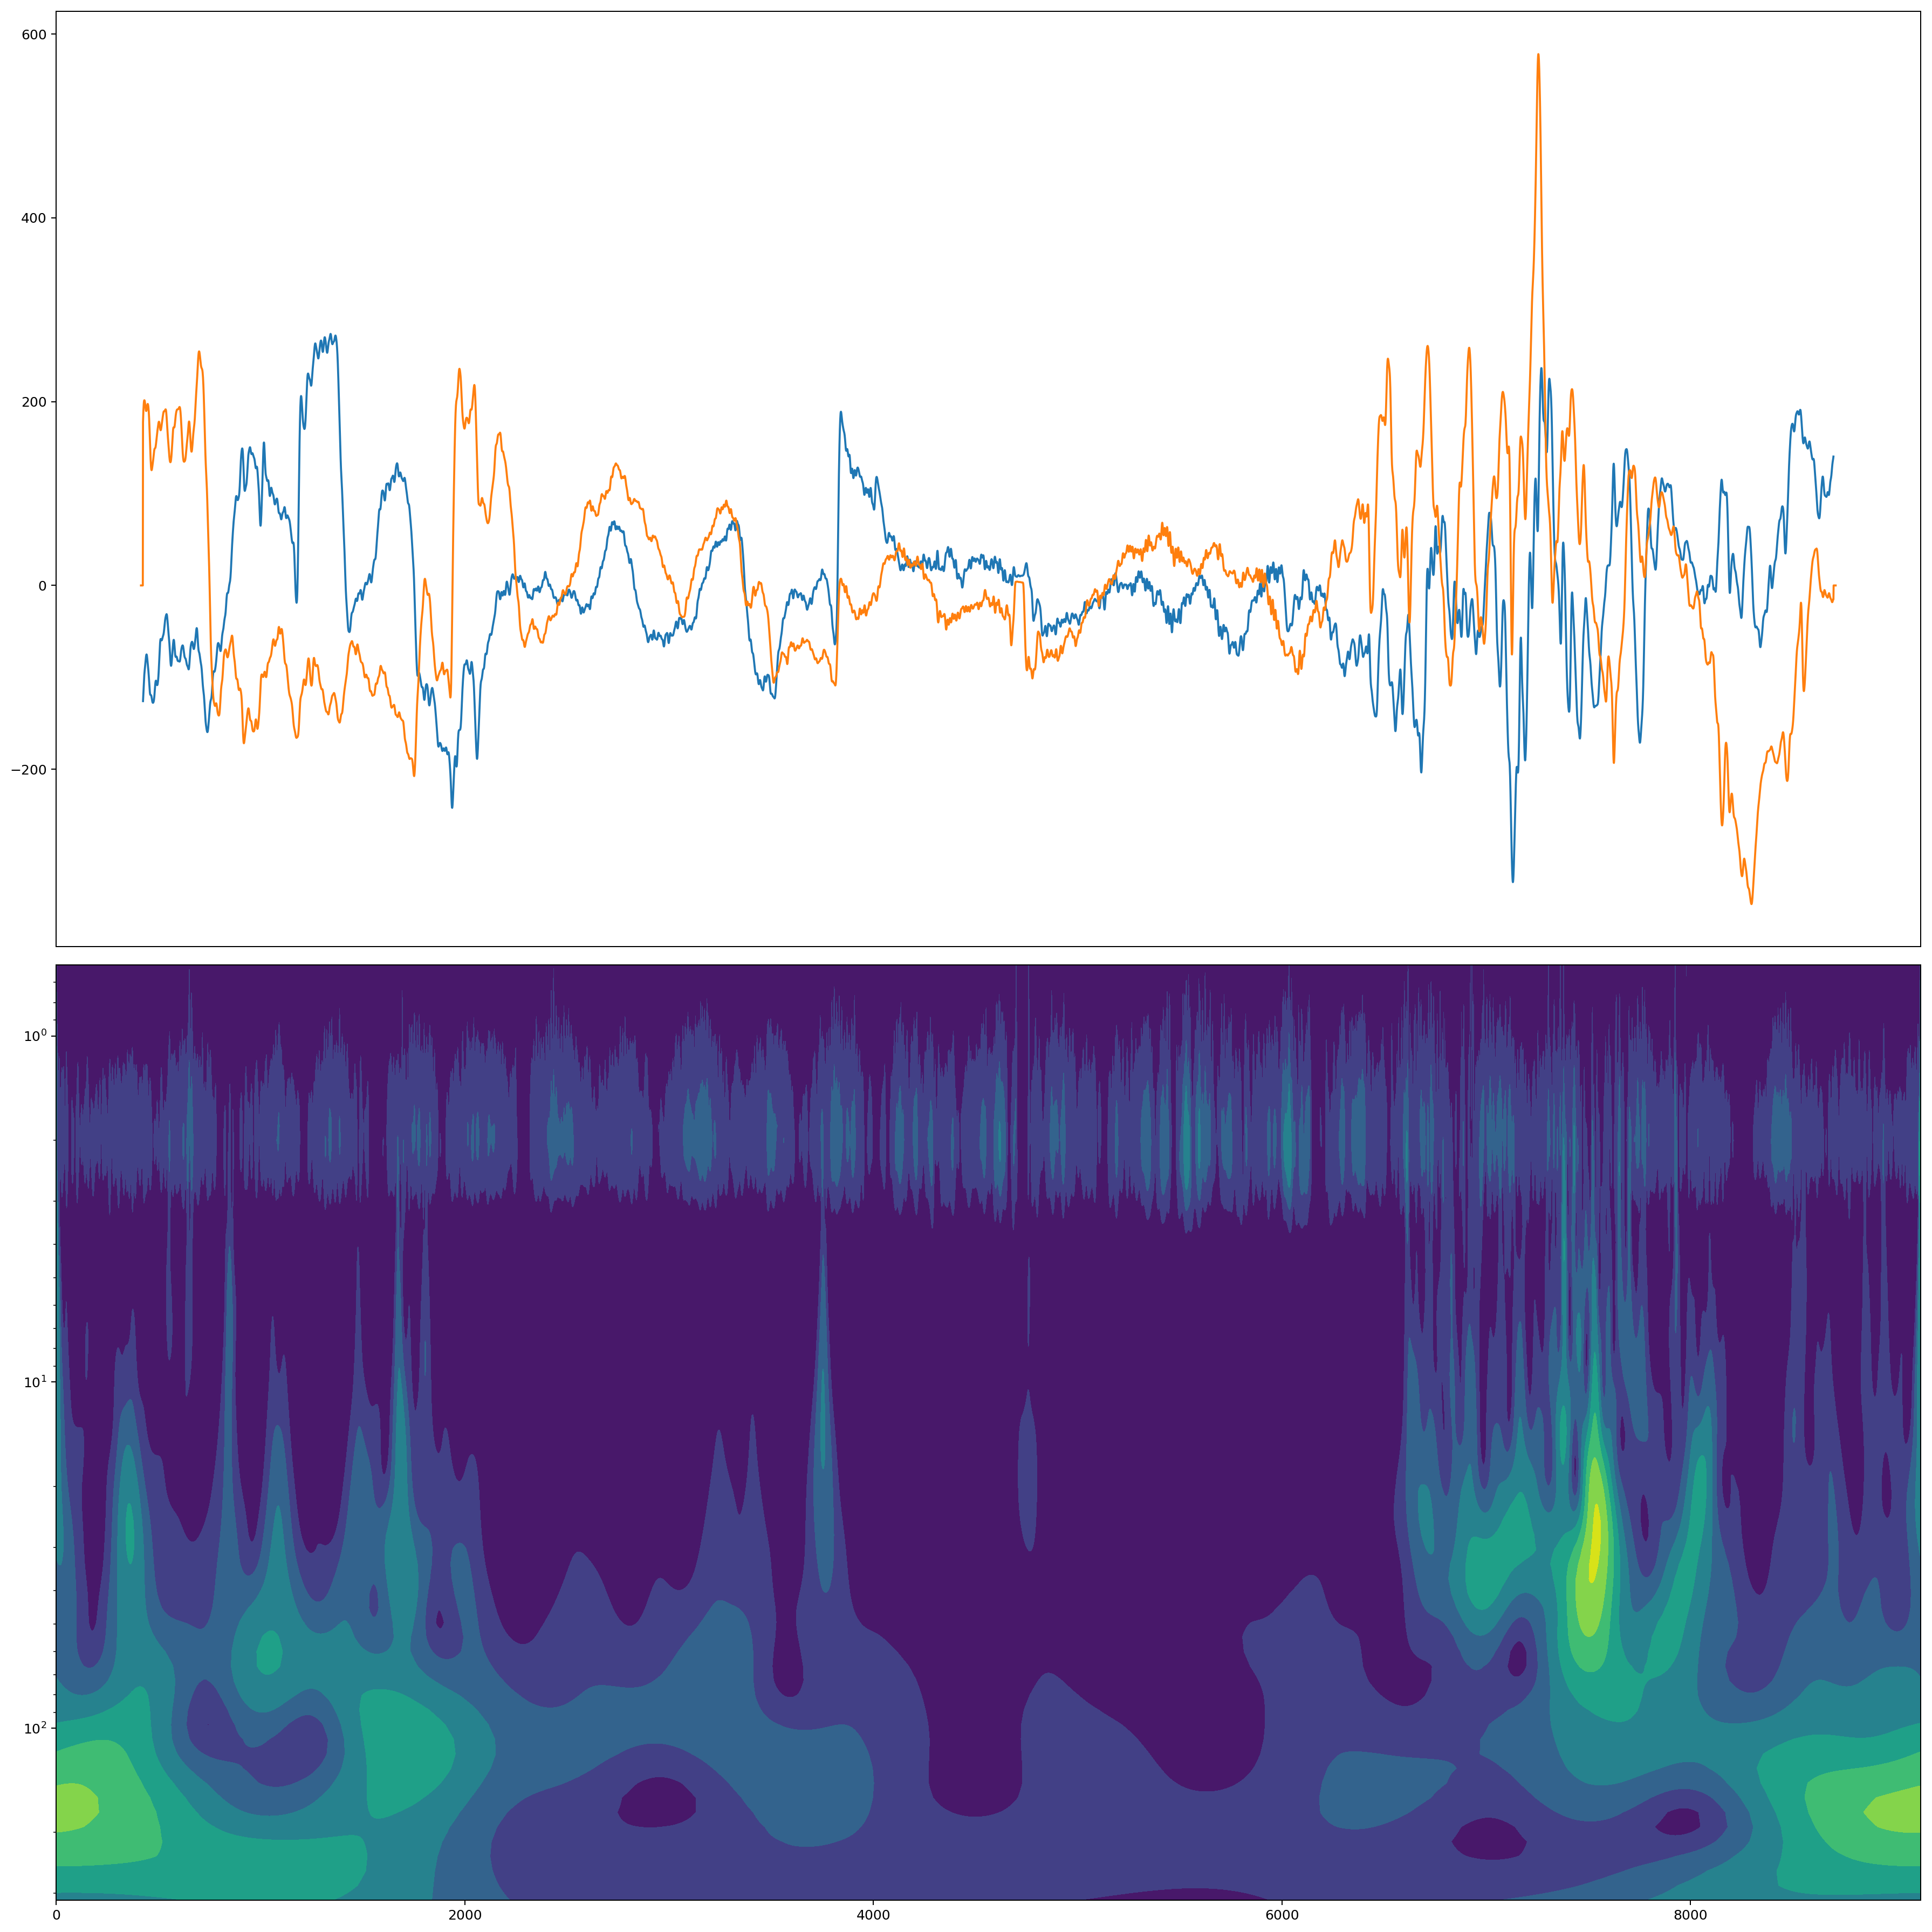

In [1]:
# analytic_wavelet_transform figure
import numpy as np
from scipy.signal.windows import hann
from scipy.signal import convolve
from analytic_wavelet import analytic_wavelet_transform, GeneralizedMorseWavelet, make_unpad_slices, masked_detrend, \
    wavelet_contourf, time_series_plot, load_test_data
%matplotlib inline
from matplotlib import pyplot as plt, gridspec

bravo94 = load_test_data('test_data/bravo94.mat')
cv = bravo94['rcm']['cv'].T
cv = cv[1]
morse = GeneralizedMorseWavelet(gamma=3, beta=2)
fs = morse.log_spaced_frequencies(high=np.pi, low=np.pi / 1000, nyquist_overlap=0.05)
pad_width = cv.shape[-1]
unpad_slices = make_unpad_slices(cv.ndim, pad_width)
cv = np.pad(masked_detrend(cv), pad_width, mode='wrap')
psi, psi_f = morse.make_wavelet(cv.shape[-1], fs)
wp = analytic_wavelet_transform(cv, psi_f, np.isrealobj(psi), unpad_slices)
wn = analytic_wavelet_transform(np.conj(cv), psi_f, np.isrealobj(psi), unpad_slices)
cv = cv[unpad_slices]

cv = convolve(cv, hann(24), mode='valid')

pad_start = (wp.shape[-1] - len(cv)) // 2
pad_end = wp.shape[-1] - len(cv) - pad_start
cv = np.pad(cv, (pad_start, pad_end), mode='constant', constant_values=np.nan)

fig = plt.figure(figsize=(20, 20), dpi=180)
grid = gridspec.GridSpec(2, 1)

ax = fig.add_subplot(grid[0, 0])
time_series_plot(ax, np.arange(wp.shape[-1]), cv)
ax.set_xticks([])

ax = fig.add_subplot(grid[1, 0])
wavelet_contourf(ax, np.arange(wp.shape[-1]), 1/fs, np.sqrt(np.square(np.abs(wp)) + np.square(np.abs(wn)))) 
ax.set_yscale('log')
ax.invert_yaxis()

fig.tight_layout()


In [1]:
# joint moments test
import numpy as np
from analytic_wavelet import analytic_transform, instantaneous_frequency, instantaneous_bandwidth, load_test_data

solomon = load_test_data('test_data/solomon.mat')
x, z = analytic_transform(np.squeeze(solomon['x'], axis=1)), analytic_transform(np.squeeze(solomon['z'], axis=1))

fx = instantaneous_frequency(x)
bx = instantaneous_bandwidth(x)
fz = instantaneous_frequency(z)
bz = instantaneous_bandwidth(z)

fxz_expected = (np.abs(x) ** 2 * fx + np.abs(z) ** 2 * fz) / (np.abs(x) ** 2 + np.abs(z) ** 2)
bxz_expected = np.sqrt(
    ((np.abs(x) ** 2 * (bx ** 2 + (fx - fxz_expected) ** 2) + np.abs(z) ** 2 * (bz ** 2 + (fz - fxz_expected) ** 2)) 
     / (np.abs(x) ** 2 + np.abs(z) ** 2)))
xz = np.array([x, z])

fxz = instantaneous_frequency(xz, variable_axis=0)
bxz = instantaneous_bandwidth(xz, variable_axis=0)

assert(np.allclose(fxz, fxz_expected))
assert(np.allclose(bxz, bxz_expected))

print('joint moments passed')

joint moments passed


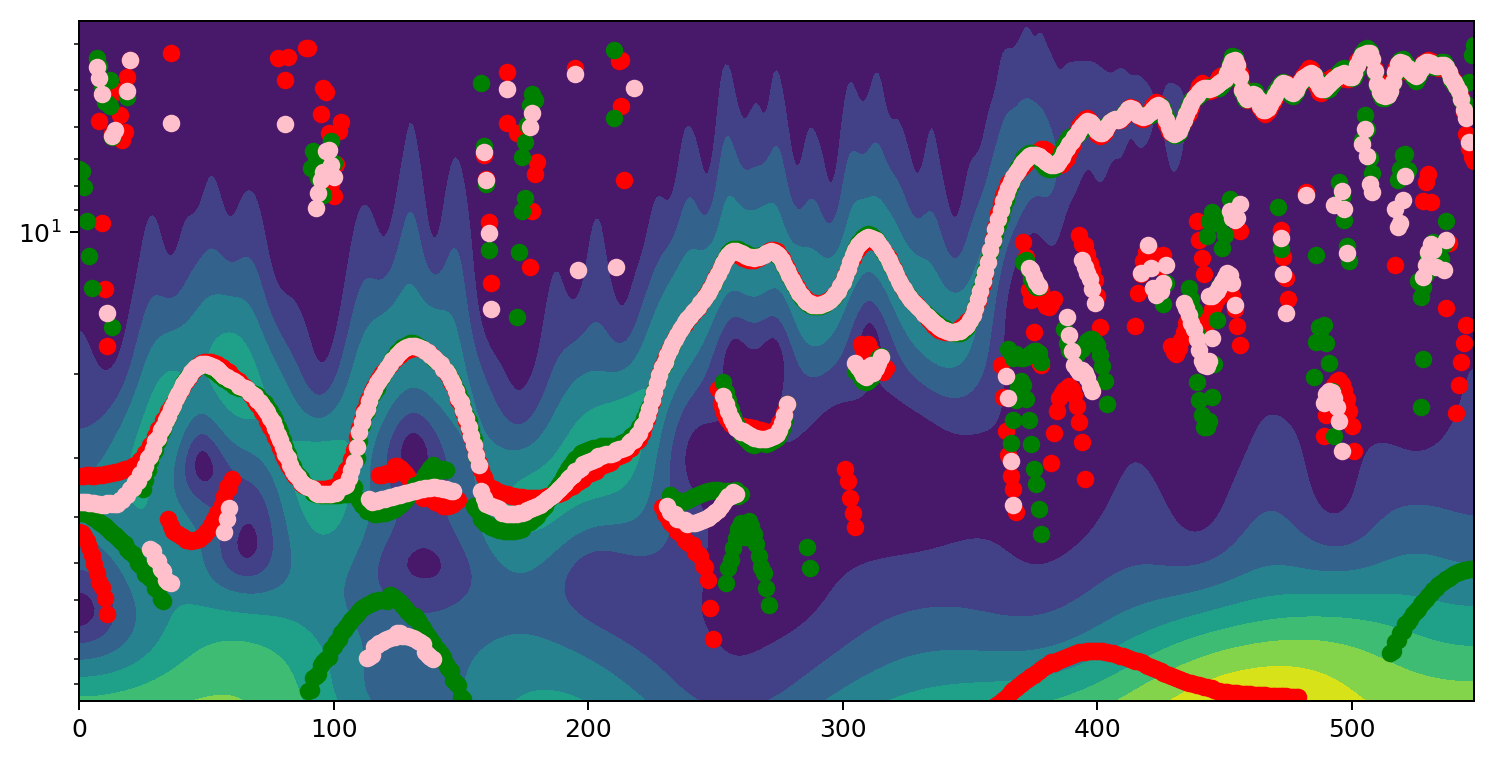

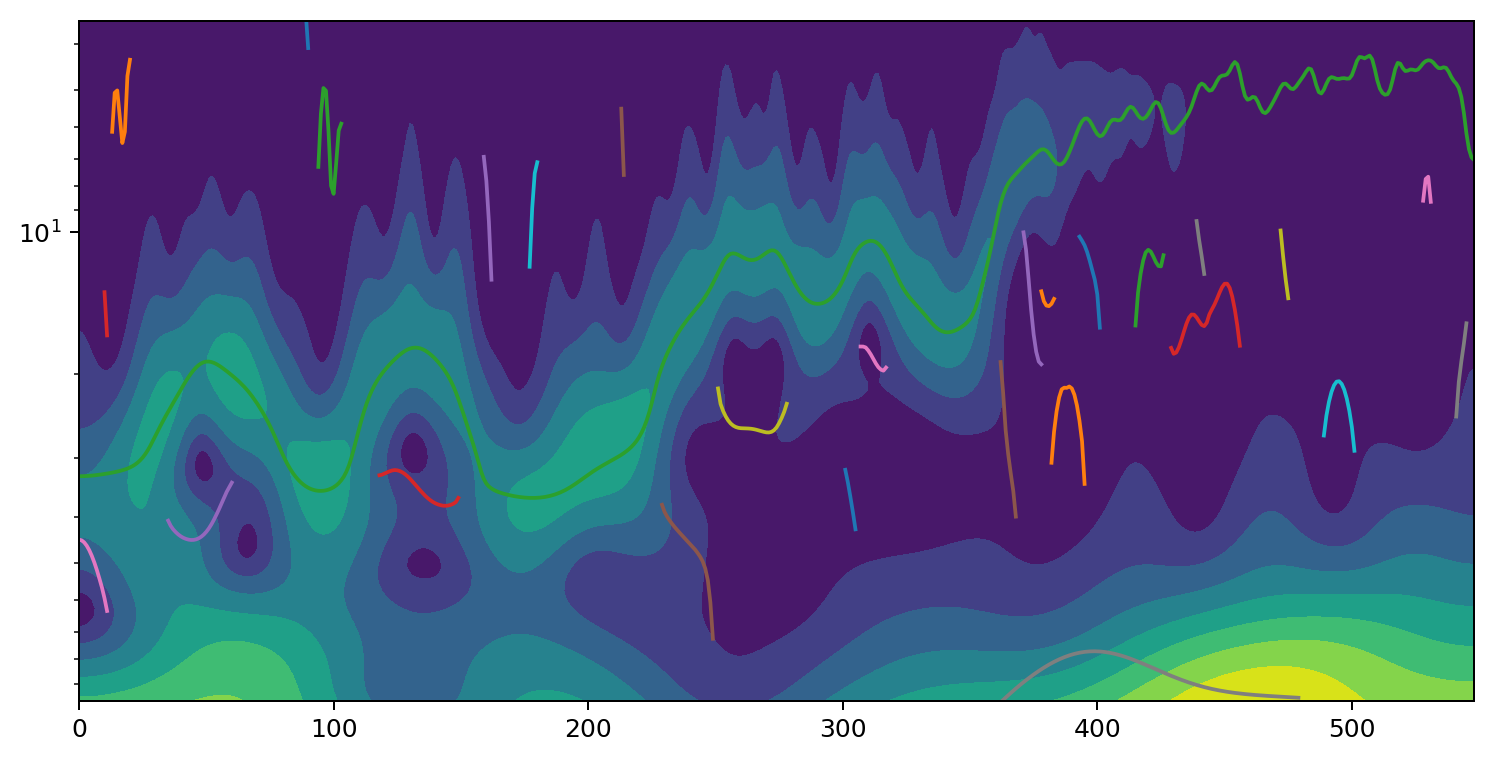

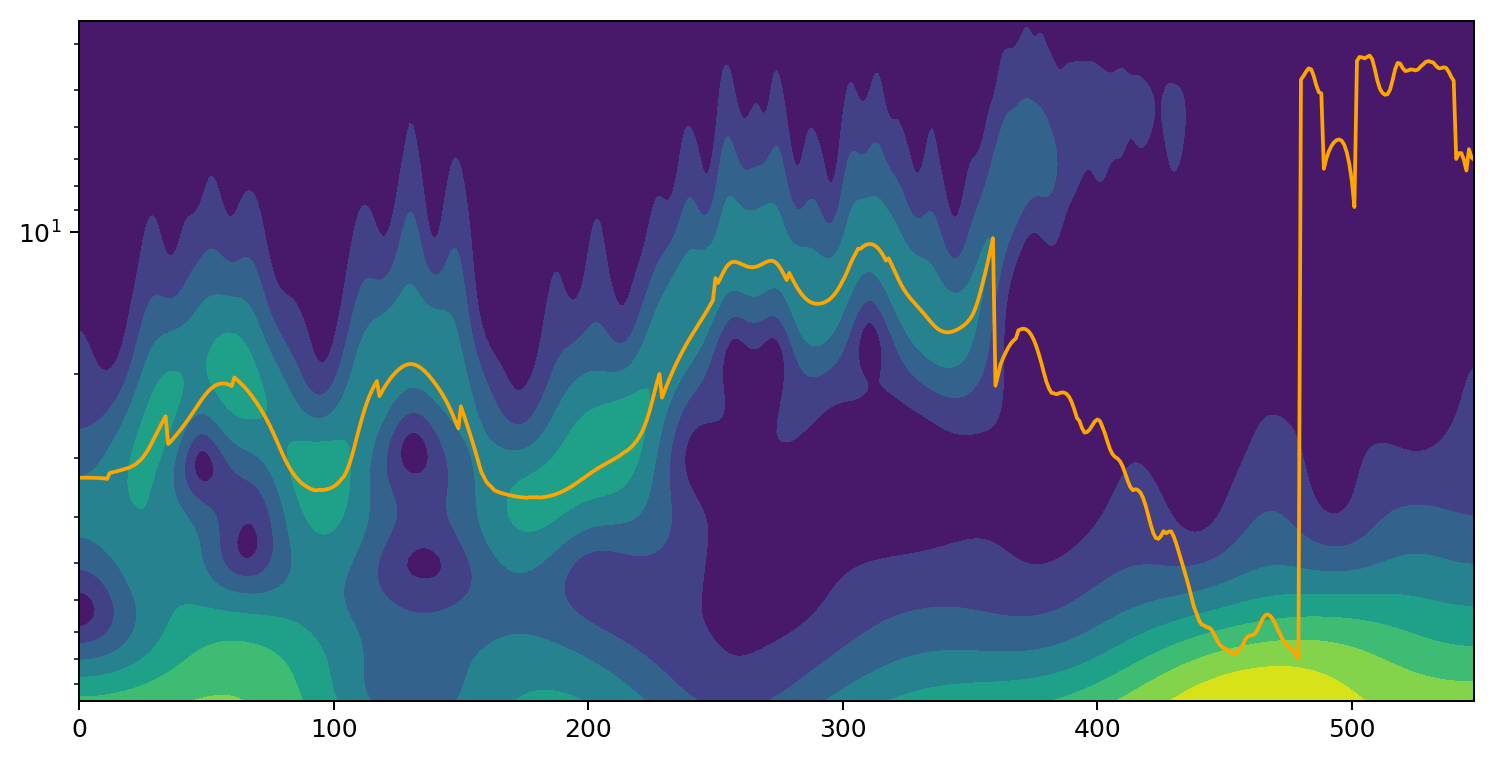

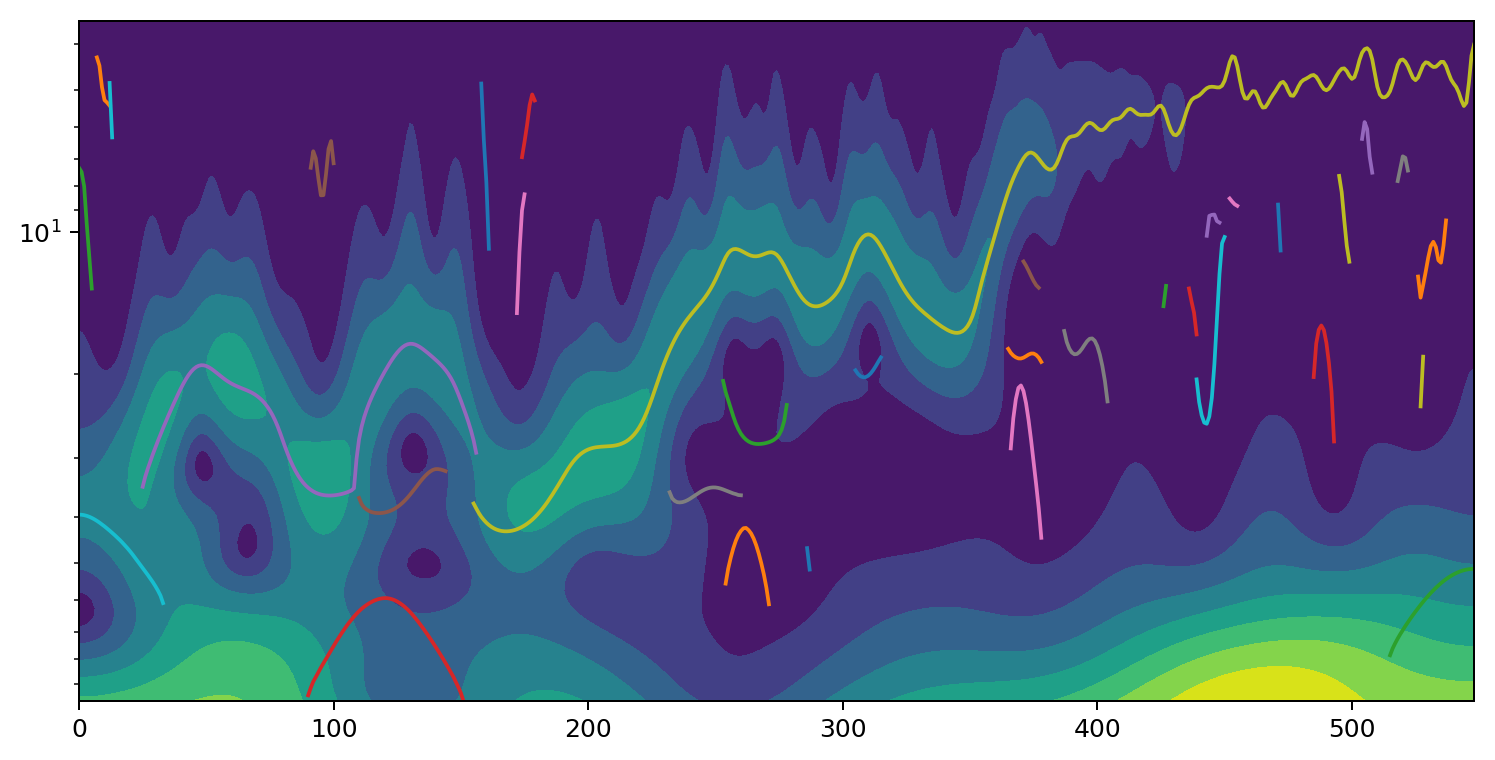

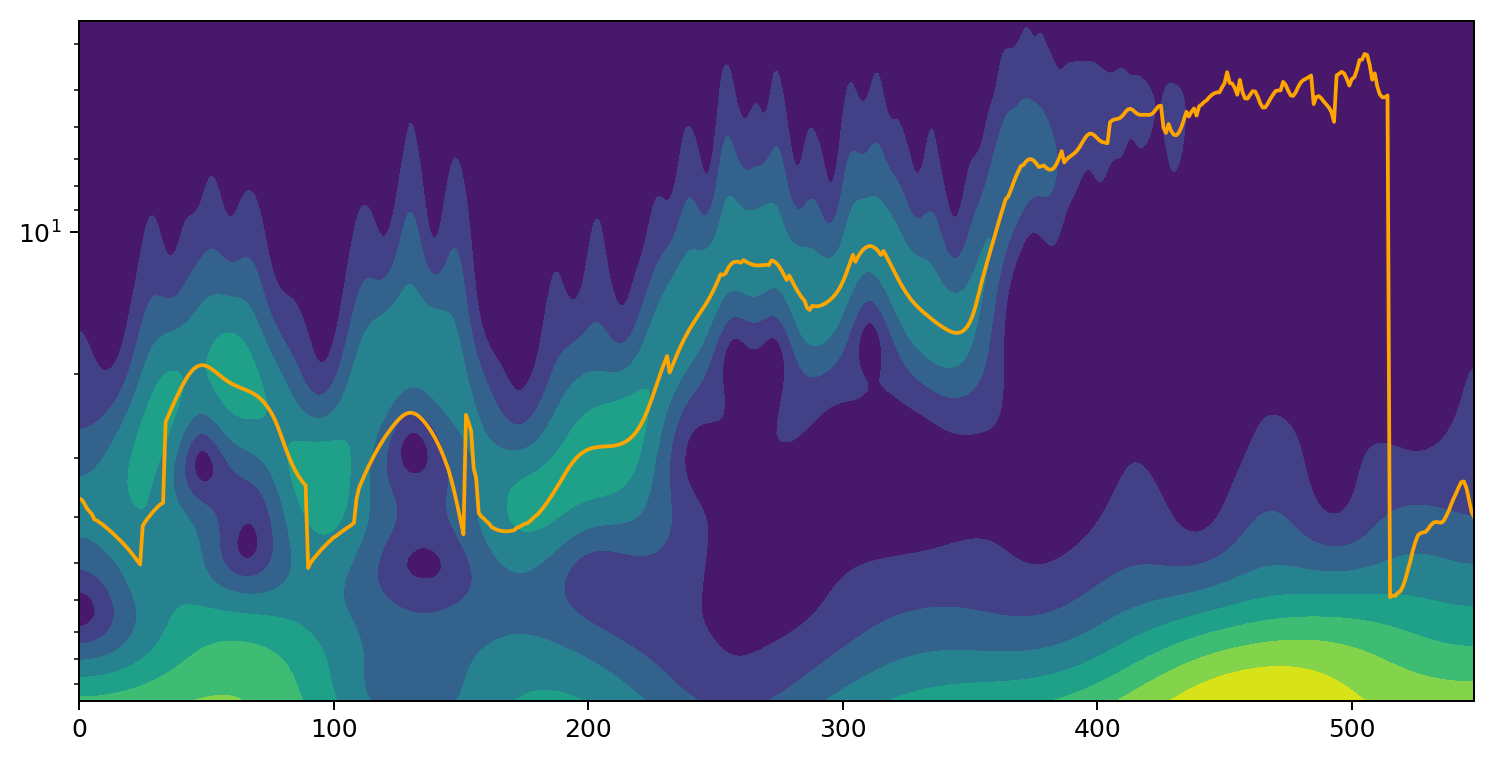

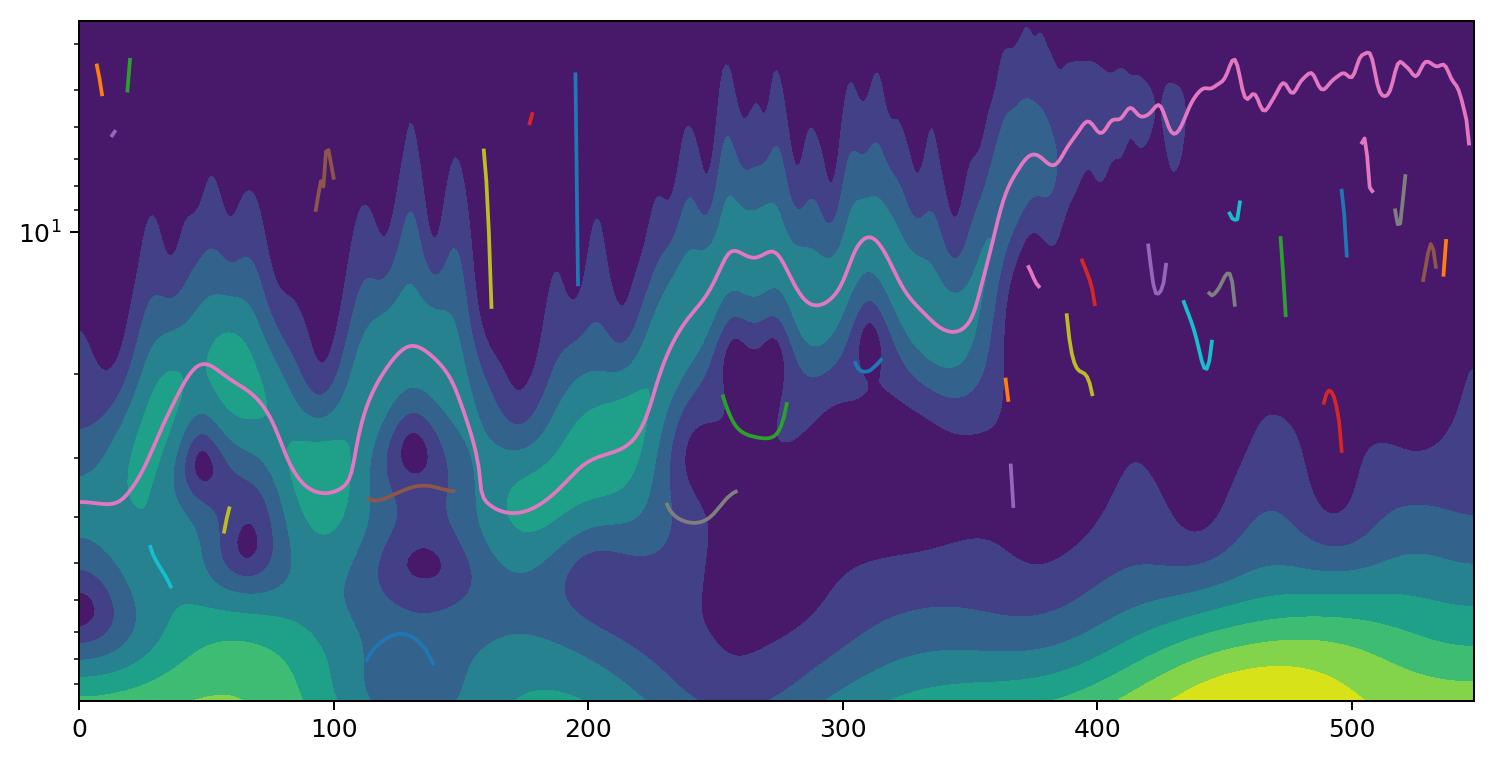

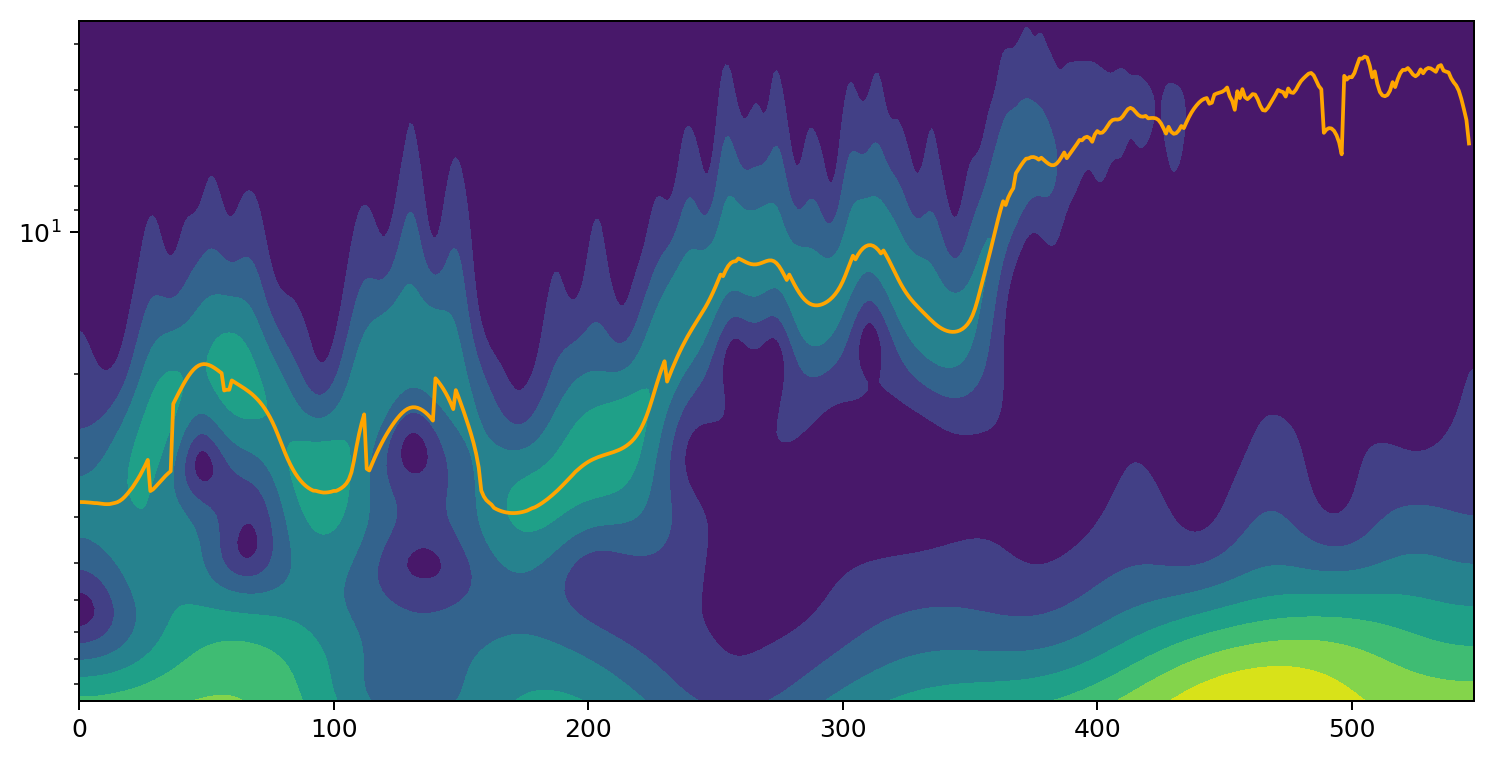

In [1]:
# ridges figure
import numpy as np
from scipy.signal.windows import hann
from scipy.signal import convolve
from analytic_wavelet import analytic_wavelet_transform, GeneralizedMorseWavelet, make_unpad_slices, masked_detrend, \
    ridges, wavelet_contourf, time_series_plot, load_test_data, RidgeRepresentation, latlon2xy, latlon2uv
from analytic_wavelet.ridge_analysis import _indicator_ridge
%matplotlib inline
from matplotlib import pyplot as plt, gridspec

ebasnfloats = load_test_data('test_data/ebasnfloats.mat')

num = np.squeeze(ebasnfloats['num'][32], axis=1)
lat = np.squeeze(ebasnfloats['lat'][32], axis=1)
lon = np.squeeze(ebasnfloats['lon'][32], axis=1)
dt = num[1] - num[0]


def interpolate_nan(x):
    indicator_nan = np.isnan(x)
    not_nan = np.logical_not(indicator_nan)
    x[indicator_nan] = np.interp(np.flatnonzero(indicator_nan), np.flatnonzero(not_nan), x[not_nan])
    

x, y = latlon2xy(lat, lon, 30, -25)
cx = x + 1j * y
interpolate_nan(cx)
cv = latlon2uv(num, lat, lon)

morse = GeneralizedMorseWavelet(gamma=3, beta=3)
fs = morse.log_spaced_frequencies(high=2 * np.pi / 3, nyquist_overlap=0.05, low=2 * np.pi / 100, density=8)
pad_width = len(cx)
unpad_slices = make_unpad_slices(cx.ndim, pad_width)
_, psi_f = morse.make_wavelet(len(cx) + 2 * pad_width, fs)
wx = analytic_wavelet_transform(np.pad(masked_detrend(np.real(cx)), pad_width, mode='reflect'), psi_f, False, unpad_slices)
wy = analytic_wavelet_transform(np.pad(masked_detrend(np.imag(cx)), pad_width, mode='reflect'), psi_f, False, unpad_slices)

def plot_ridge_points(plot_wx=True, plot_wy=True, plot_w=True):
    fig = plt.figure(figsize=(10, 5), dpi=180)
    ax = fig.add_subplot(111)
    wavelet_contourf(ax, np.arange(wx.shape[-1]), 2 * np.pi / fs, np.sqrt(np.square(np.abs(wx)) + np.square(np.abs(wy))))

    # save these because scatter plot messes up the limits (in case we are plotting ridge points)
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    # wx ridge points in red
    if plot_wx:
        indicator, _, inst_freq = _indicator_ridge(np.expand_dims(wx, 0), fs, 'amplitude', 0, None, None, None)
        indices = np.nonzero(np.squeeze(indicator, axis=0))
        ax.scatter(indices[1], 2 * np.pi / np.squeeze(inst_freq, axis=0)[indices], color='red')

    # wy ridge points in green
    if plot_wy:
        indicator, _, inst_freq = _indicator_ridge(np.expand_dims(wy, 0), fs, 'amplitude', 0, None, None, None)
        indices = np.nonzero(np.squeeze(indicator, axis=0))
        ax.scatter(indices[1], 2 * np.pi / np.squeeze(inst_freq, axis=0)[indices], color='green')

    # joint ridge points in pink
    if plot_w:
        w = np.array([wx, wy])
        indicator, _, inst_freq = _indicator_ridge(np.expand_dims(w, 0), fs, 'amplitude', 0, None, None, None)
        indices = np.nonzero(np.squeeze(indicator, axis=0))
        ax.scatter(indices[1], 2 * np.pi / np.squeeze(inst_freq, axis=0)[indices], color='pink')

    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.invert_yaxis()
    plt.show()


def plot_ridges(w):
    fig = plt.figure(figsize=(10, 5), dpi=180)
    ax = fig.add_subplot(111)
    wavelet_contourf(ax, np.arange(wx.shape[-1]), 2 * np.pi / fs, np.sqrt(np.square(np.abs(wx)) + np.square(np.abs(wy))))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    w_ridges = ridges(
        w, fs, dt=dt, morse_wavelet=morse, min_wavelet_lengths_in_ridge=4 / (2 * morse.time_domain_width() / np.pi), 
        variable_axis=0 if w.ndim == 3 else None)
    
    fr = w_ridges.instantaneous_frequency(representation=RidgeRepresentation.compressed)
    if w.ndim == 3:
        fr = np.squeeze(fr, axis=0)
        
    for item in fr:
        ax.plot(np.arange(len(item)), 2 * np.pi / item)
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.invert_yaxis()
    plt.show()
    
    fig = plt.figure(figsize=(10, 5), dpi=180)
    ax = fig.add_subplot(111)
    wavelet_contourf(ax, np.arange(wx.shape[-1]), 2 * np.pi / fs, np.sqrt(np.square(np.abs(wx)) + np.square(np.abs(wy))))
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()

    collapsed = w_ridges.collapse()
    fr = collapsed.instantaneous_frequency(representation=RidgeRepresentation.compressed)
    if w.ndim == 3:
        fr = np.squeeze(fr, axis=0)
        
    for item in fr:
        ax.plot(np.arange(len(item)), 2 * np.pi / item, color='orange')
        
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)
    ax.set_yscale('log')
    ax.invert_yaxis()
    plt.show()
    

plot_ridge_points()
plot_ridges(wx)
plot_ridges(wy)
plot_ridges(np.array([wx, wy]))

In [15]:
# GeneralizedMorseWavelet taylor_expansion_time_domain_wavelet
import numpy as np
from analytic_wavelet import GeneralizedMorseWavelet
%matplotlib inline
from matplotlib import pyplot as plt
morse = GeneralizedMorseWavelet(gamma=3, beta=6)
t = np.arange(-500, 501)
fs = 2 * np.pi / 20 
psi = morse.taylor_expansion_time_domain_wavelet(t, fs)
psi_2, _ = morse.make_wavelet(len(t), fs)

# fig = plt.figure(figsize=(5, 5), dpi=180)
# ax = fig.add_subplot(111)
# ax.plot(t, np.abs(psi))
# ax.plot(t, np.squeeze(np.abs(psi_2), axis=0), linestyle='--')
# plt.show()

grad_psi = np.gradient(psi)
psi = np.where(np.logical_or(grad_psi * t > 0, np.isnan(grad_psi)), np.nan, psi)
psi[0] = np.nan
psi[-1] = np.nan
err = np.nansum(np.abs(psi - psi_2) ** 2)
assert(err < 1e-4)

psi_2 = morse.taylor_expansion_time_domain_wavelet(t, fs, use_cumulant=True)
err = np.nansum(np.abs(psi - psi_2) ** 2)
assert(err < 1e-4)

print('taylor expansion passed')

taylor expansion passed


C:\Users\danrs\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: RuntimeWarning: invalid value encountered in greater
C:\Users\danrs\Documents\analytic_wavelet\analytic_wavelet\generalized_morse_wavelet.py:452: RuntimeWarning: overflow encountered in exp
  psi = np.exp(psi)
C:\Users\danrs\Documents\analytic_wavelet\analytic_wavelet\generalized_morse_wavelet.py:453: RuntimeWarning: invalid value encountered in multiply
  psi = (1 / s) * psi
C:\Users\danrs\Documents\analytic_wavelet\analytic_wavelet\generalized_morse_wavelet.py:459: RuntimeWarning: invalid value encountered in greater
  result = np.where(np.abs(psi) > np.abs(psi0) * 1.05, np.nan, psi)


In [11]:
# test _noise_covariance helper of distribution_of_maxima_of_transformed_noise
import numpy as np
from scipy.signal import detrend
from analytic_wavelet import GeneralizedMorseWavelet, distribution_of_maxima_of_transformed_noise, \
    make_unpad_slices, analytic_wavelet_transform
from analytic_wavelet.element_analysis import _noise_covariance

for alpha in (0, 1):
    morse = GeneralizedMorseWavelet(gamma=2, beta=2)
    fs = morse.log_spaced_frequencies(nyquist_overlap=0.01, high=np.pi, low=2 * np.pi / 100)
    np.random.seed(42)
    x = np.random.randn(int(1e6))
    if alpha == 1:
        x = np.cumsum(x)        
        x = x / np.std(x)
    
    pad_width = len(x)
    unpad_slices = make_unpad_slices(x.ndim, pad_width)
    _, psi_f = morse.make_wavelet(len(x) + 2 * pad_width, fs[:3])
    w = analytic_wavelet_transform(
        np.pad(detrend(x), pad_width, mode='symmetric'), psi_f, False, unpad_slices=unpad_slices)
    
    x_vec = [
        w[1],
        np.roll(w[1], -1),
        np.roll(w[1], 1),
        w[2],
        w[0]]
    
    sigma_hat = np.full((5, 5), np.nan, dtype=w.dtype)
    for i in range(5):
        for j in range(5):
            sigma_hat[i, j] = np.mean(x_vec[i] * np.conj(x_vec[j]))
    sigma_hat = sigma_hat / np.mean(np.square(np.abs(x_vec[0])))
    
    sigma = _noise_covariance(morse, alpha, fs[0] / fs[1], morse.peak_frequency() / fs[1])
    
    tol = 1 / 100 if alpha == 0 else 4 / 100 if alpha == 1 else None
    assert(tol is not None)
    assert(np.max(np.abs(sigma - sigma_hat) / np.abs(sigma)) < tol)
print('_noise_covariance passed')

_noise_covariance passed


In [1]:
from collections import OrderedDict
import numpy as np
from analytic_wavelet import distribution_of_maxima_of_transformed_noise, GeneralizedMorseWavelet
from tqdm import tqdm

morse = GeneralizedMorseWavelet(gamma=2, beta=2)
num_samples = int(1e7)

fs = morse.log_spaced_frequencies(
    num_timepoints=12000, high=np.pi, nyquist_overlap=0.05, endpoint_overlap=3)
fs = fs[:50]

variations = OrderedDict(
    # white_noise=dict(spectral_slope=0, make_p_value_func=False, should_extrapolate=False),
    white_noise_density=dict(spectral_slope=0, make_p_value_func=True, should_extrapolate=False),
    white_noise_extrapolate=dict(spectral_slope=0, make_p_value_func=True, should_extrapolate=True),
    red_noise=dict(spectral_slope=1, make_p_value_func=False, should_extrapolate=False),
    red_noise_density=dict(spectral_slope=1, make_p_value_func=True, should_extrapolate=False),
    red_noise_extrapolate=dict(spectral_slope=1, make_p_value_func=True, should_extrapolate=True))

noise_distribution_result = OrderedDict()
print('Computing distributions...')
tqdm_it = tqdm(variations)
for variation in tqdm_it:
    tqdm_it.set_description(variation)
    tqdm_it.refresh()
    variation_result = distribution_of_maxima_of_transformed_noise(
        morse=morse, scale_frequencies=fs, num_monte_carlo_realizations=num_samples, bins=100,
        **variations[variation])
    noise_distribution_result[variation] = dict(
        hist=variation_result[0], 
        bin_edges=variation_result[1], 
        p_value_func=variation_result[2] if len(variation_result) > 2 else None)

Computing distributions...


white_noise_density:   0%|                                                                                                                                 | 0/5 [00:00<?, ?it/s]

26.62655750410594
[1.04038438e-03 3.64134534e-03 1.22245165e-02 2.49692252e-02
 4.70773933e-02 7.90692131e-02 1.17303339e-01 1.80506690e-01
 2.53853789e-01 3.50349441e-01 4.84819122e-01 6.41917164e-01
 8.37769524e-01 1.06717428e+00 1.32284874e+00 1.64380732e+00
 2.00039907e+00 2.39678552e+00 2.84831234e+00 3.33313147e+00
 3.85722510e+00 4.44114083e+00 5.06589166e+00 5.70546795e+00
 6.42463366e+00 7.17657147e+00 7.94749630e+00 8.74781199e+00
 9.58714209e+00 1.04514414e+01 1.12905114e+01 1.21503891e+01
 1.30113072e+01 1.38399733e+01 1.47193582e+01 1.55560874e+01
 1.63629055e+01 1.71546380e+01 1.79078763e+01 1.86356252e+01
 1.93300817e+01 1.99891652e+01 2.06071536e+01 2.11697414e+01
 2.17068399e+01 2.22023229e+01 2.26795993e+01 2.31176011e+01
 2.35087856e+01 2.38692788e+01 2.41863359e+01 2.44849263e+01
 2.47634892e+01 2.50001766e+01 2.52147559e+01 2.54085275e+01
 2.55856529e+01 2.57307866e+01 2.58613548e+01 2.59713754e+01
 2.60665706e+01 2.61500615e+01 2.62257494e+01 2.62951951e+01
 2.635

 2.62209439e+01 2.62209439e+01 2.62209439e+01 2.62214173e+01]
26.044677325354474
[2.13485336e-03 4.80342007e-03 1.38765469e-02 2.29496737e-02
 4.05622139e-02 7.04501610e-02 1.09944948e-01 1.61181429e-01
 2.41238430e-01 3.25031425e-01 4.37111226e-01 5.80146402e-01
 7.61608938e-01 9.70290854e-01 1.20138873e+00 1.50507162e+00
 1.81622650e+00 2.21918007e+00 2.63707762e+00 3.09126767e+00
 3.63992499e+00 4.23448165e+00 4.85198798e+00 5.48657315e+00
 6.20441759e+00 6.95001513e+00 7.76286054e+00 8.57623968e+00
 9.40402907e+00 1.02510321e+01 1.10841587e+01 1.19279595e+01
 1.27963111e+01 1.36086228e+01 1.44860475e+01 1.53453260e+01
 1.61389577e+01 1.69437974e+01 1.76643104e+01 1.83517332e+01
 1.90551674e+01 1.97020280e+01 2.03456863e+01 2.09311698e+01
 2.14782260e+01 2.19660400e+01 2.23930106e+01 2.27900934e+01
 2.31636927e+01 2.34972635e+01 2.37860025e+01 2.40651345e+01
 2.43063730e+01 2.45348023e+01 2.47381471e+01 2.49105365e+01
 2.50701168e+01 2.51939383e+01 2.53102878e+01 2.54191653e+01
 2.5

 2.93292484e+01 2.93292484e+01 2.93292484e+01 2.93303423e+01]
28.133981649428627
[4.64123094e-03 1.85649238e-02 3.82901553e-02 6.72978486e-02
 9.39849265e-02 1.35756005e-01 1.91450776e-01 2.52947086e-01
 3.33008320e-01 4.38596324e-01 5.80153867e-01 7.34474796e-01
 9.37528650e-01 1.18235358e+00 1.48519390e+00 1.80659914e+00
 2.17905793e+00 2.55615794e+00 2.97967026e+00 3.46583920e+00
 4.00306169e+00 4.54144447e+00 5.19585804e+00 5.79341652e+00
 6.49076147e+00 7.23915996e+00 7.99335999e+00 8.74639971e+00
 9.54585174e+00 1.03487847e+01 1.11749238e+01 1.20231087e+01
 1.28933396e+01 1.36835091e+01 1.45502590e+01 1.53601538e+01
 1.61828120e+01 1.69729815e+01 1.77782351e+01 1.85289542e+01
 1.92808336e+01 2.00025450e+01 2.06476761e+01 2.12904866e+01
 2.19031291e+01 2.24217867e+01 2.29833756e+01 2.34927507e+01
 2.39638357e+01 2.43827067e+01 2.47586464e+01 2.51137006e+01
 2.54478692e+01 2.57797173e+01 2.60558705e+01 2.63215810e+01
 2.65791693e+01 2.67810628e+01 2.69609105e+01 2.71036284e+01
 2.7

 2.99308153e+01 2.99308153e+01 2.99330635e+01 2.99353118e+01]
32.34147710138586
[1.35968541e-02 2.71937081e-02 4.35099330e-02 6.25455287e-02
 8.43004953e-02 1.22371687e-01 1.52284766e-01 2.06672182e-01
 2.85533936e-01 3.75273172e-01 4.67731780e-01 6.09139063e-01
 7.85898166e-01 9.49060414e-01 1.14213574e+00 1.33249170e+00
 1.63162249e+00 1.90084020e+00 2.19725162e+00 2.52085675e+00
 2.86077810e+00 3.29315806e+00 3.80439977e+00 4.30204463e+00
 4.92478055e+00 5.53120024e+00 6.13761993e+00 6.79842704e+00
 7.47555037e+00 8.21249986e+00 8.97664306e+00 9.81148990e+00
 1.05837912e+01 1.13397763e+01 1.22398880e+01 1.31264029e+01
 1.40645859e+01 1.49701363e+01 1.58294575e+01 1.68057116e+01
 1.76487166e+01 1.84400535e+01 1.92504260e+01 2.00009723e+01
 2.07678349e+01 2.14476776e+01 2.21683109e+01 2.29025410e+01
 2.35252769e+01 2.42268746e+01 2.48686461e+01 2.54913820e+01
 2.60352562e+01 2.65002686e+01 2.70142297e+01 2.74520484e+01
 2.78572346e+01 2.83440020e+01 2.87219945e+01 2.90945483e+01
 2.94

 3.14083472e+01 3.14083472e+01 3.14083472e+01 3.14130717e+01]
31.351939052959
[5.40737134e-03 5.40737134e-03 2.16294854e-02 3.24442281e-02
 4.86663421e-02 7.02958275e-02 9.19253128e-02 1.18962170e-01
 1.51406398e-01 1.83850626e-01 2.75775939e-01 3.51479137e-01
 4.92070792e-01 6.59699304e-01 8.05698330e-01 9.94956327e-01
 1.18421432e+00 1.37347232e+00 1.68709986e+00 2.05480111e+00
 2.46035396e+00 2.89835104e+00 3.37960709e+00 3.86627051e+00
 4.43404450e+00 5.02885535e+00 5.56418511e+00 6.13195910e+00
 6.85654686e+00 7.59735674e+00 8.27327816e+00 9.07897649e+00
 9.83600847e+00 1.06362994e+01 1.15393304e+01 1.23936951e+01
 1.32750966e+01 1.41889424e+01 1.49838260e+01 1.59193012e+01
 1.68007028e+01 1.77145485e+01 1.84932100e+01 1.91961683e+01
 2.01370509e+01 2.08832681e+01 2.15537822e+01 2.22621478e+01
 2.29326619e+01 2.35653243e+01 2.42196163e+01 2.47603534e+01
 2.52902758e+01 2.58310129e+01 2.62906395e+01 2.67178218e+01
 2.71179673e+01 2.74856685e+01 2.78587772e+01 2.81886268e+01
 2.8561

 3.30834561e+01 3.30834561e+01 3.30834561e+01 3.30937241e+01]
34.397115717507084
[1.23242980e-02 1.23242980e-02 4.92971920e-02 6.16214900e-02
 9.85943840e-02 1.47891576e-01 2.09513066e-01 2.34161662e-01
 2.95783152e-01 3.32756046e-01 3.94377536e-01 4.68323324e-01
 5.66917708e-01 7.39457880e-01 9.73619542e-01 1.29405129e+00
 1.46659146e+00 1.66378023e+00 2.03350917e+00 2.42788671e+00
 2.72366986e+00 3.16734459e+00 3.46312774e+00 3.86982957e+00
 4.36280149e+00 4.99134069e+00 5.58290699e+00 6.19912189e+00
 7.00020126e+00 7.82592923e+00 8.62700860e+00 9.56365525e+00
 1.01675458e+01 1.08823551e+01 1.15848401e+01 1.24475410e+01
 1.32362961e+01 1.41113212e+01 1.50356436e+01 1.59846145e+01
 1.68349911e+01 1.75374761e+01 1.82522853e+01 1.91889320e+01
 2.00516328e+01 2.07048206e+01 2.13580084e+01 2.20358448e+01
 2.28369242e+01 2.36503279e+01 2.43404885e+01 2.48827577e+01
 2.54496754e+01 2.60412417e+01 2.66821052e+01 2.73106444e+01
 2.77419948e+01 2.83705340e+01 2.88758302e+01 2.92332349e+01
 2.9

 3.73166859e+01 3.73619457e+01 3.73845756e+01 3.74072054e+01]
35.29568734687947
[ 0.05049455  0.12623636  0.17673091  0.17673091  0.22722546  0.35346182
  0.40395636  0.53019273  0.53019273  0.65642909  0.90890182  1.21186909
  1.43909455  1.66632     1.99453455  2.27225455  2.72670546  3.10541455
  3.48412364  3.76184364  4.69599274  5.42816365  6.13508729  6.91775274
  7.52368729  8.12962184  8.98802911  9.6444582  10.40187639 11.48750912
 12.39641094 13.33056003 14.21421458 15.04737458 15.80479276 16.53696367
 17.42061822 18.35476731 19.16268004 20.09682913 20.85424732 21.46018186
 22.26809459 23.10125459 23.98490914 24.51510187 25.12103642 25.72697096
 26.35815278 26.9893346  27.77200006 28.37793461 28.7566437  29.23634188
 29.66554552 30.1452437  30.65018916 30.9784037  31.35711279 31.60958552
 31.83681098 32.13977825 32.49324007 32.79620734 33.0234328  33.22541098
 33.45263643 33.62936734 33.95758189 34.1343128  34.23530189 34.4120328
 34.53826916 34.58876371 34.74024735 34.76549

 31.08576922 31.12562277 31.12562277 31.16547632]
34.85240059350582
[ 0.14034524  0.14034524  0.14034524  0.28069047  0.42103571  0.56138095
  0.60816269  0.79528968  0.98241666  1.26310714  1.59057936  1.68414285
  1.96483332  2.29230554  2.47943253  2.90046824  3.04081347  3.50863093
  4.16357537  4.58461108  5.56702775  6.26875393  6.68978964  7.62542456
  8.32715075  9.16922217  9.87094836 10.61945629 11.69543644 12.25681739
 13.14567056 13.98774198 14.97015864 15.90579356 16.84142847 17.58993641
 18.29166259 18.89982529 19.88224195 20.53718639 20.77109512 21.65994829
 22.45523797 23.25052764 24.04581732 24.60719827 25.02823398 25.68317842
 26.29134112 26.75915858 27.46088476 28.1158292  28.63042841 28.91111888
 29.47249983 29.89353554 30.361353   30.82917046 31.10986093 31.39055141
 31.57767839 31.85836886 32.04549585 32.27940458 32.56009505 32.74722203
 32.93434902 33.26182124 33.35538473 33.58929346 33.82320219 34.05711092
 34.10389266 34.2442379  34.2442379  34.2442379  34.2910

 35.72172719 35.72172719 35.72172719 35.82587217]
41.075177631019464
[ 0.13646238  0.27292477  0.40938715  0.40938715  0.54584954  0.68231192
  0.68231192  0.68231192  0.95523669  1.09169907  1.50108623  1.77401099
  1.77401099  1.91047338  2.18339815  2.86571007  2.86571007  3.27509722
  3.4115596   4.09387152  4.09387152  5.04910821  5.59495775  6.0043449
  6.14080729  7.50543113  7.64189351  8.5971302   9.96175404 10.64406596
 11.73576504 12.28161457 12.82746411 13.50977603 14.19208795 14.6014751
 15.28378703 15.82963656 16.51194848 17.46718517 17.87657232 18.42242186
 18.9682714  20.19643286 21.01520716 21.97044385 23.19860531 24.153842
 25.51846584 27.01955206 27.5654016  28.24771352 28.79356306 29.61233736
 30.84049882 31.52281074 32.20512266 32.7509722  32.88743458 33.16035935
 33.84267127 34.66144558 35.07083273 35.61668226 36.1625318  36.84484372
 36.84484372 37.11776849 37.52715564 37.52715564 37.66361803 37.80008041
 37.9365428  38.07300518 38.7553171  39.02824187 39.1647042

AssertionError: 

In [3]:

import numpy as np
from analytic_wavelet import distribution_of_maxima_of_transformed_noise, GeneralizedMorseWavelet, \
    ModulusPValueInterp2d
%matplotlib inline
from matplotlib import pyplot as plt

def multi_hist(ax, variation):
    
    hist = noise_distribution_result[variation]['hist']
    bin_edges = noise_distribution_result[variation]['bin_edges']
    
    # fill under the min values
    max_len = max(len(h) for h in hist)
    for idx_bin in range(max_len):
        y = min(h[idx_bin] for h in hist if len(h) > idx_bin)
        x1 = max(b[idx_bin] for b in bin_edges if len(b) > idx_bin)
        x2 = min(b[idx_bin + 1] for b in bin_edges if len(b) > idx_bin + 1)
        ax.fill([x1, x2, x2, x1], [0, 0, y, y], color='black')
    
    colors = [None] * len(hist[0])
    # plot the first bin and remember the colors
    for index_hist in range(len(hist)):
        y = hist[index_hist][0]
        x1 = bin_edges[index_hist][0]
        x2 = bin_edges[index_hist][1]
        h = ax.plot([x1, x2], [y, y])
        colors[index_hist] = h[0].get_color()
    
    for h, b, c in zip(hist, bin_edges, colors):
        for i in range(1, len(h)):
            ax.plot([b[i], b[i + 1]], [h[i], h[i]], color=c)

            
def sample_p_value_func(p_func):
    amp_sample = np.linspace(0, 5, 1000)
    fs_sample = np.linspace(fs[0], fs[-1], 1000)
    amp_mesh, fs_mesh = np.meshgrid(amp_mesh, fs_mesh)
    amp_mesh = np.reshape(amp_mesh, -1)
    fs_mesh = np.reshape(fs_mesh, -1)
    p_values = np.reshape(
        p_func(np.reshape(amp_mesh, -1), np.reshape(fs_mesh, -1)), (len(amp_sample), len(fs_sample)))
    return amp_sample, fs_sample, p_values


def close_p_value_func(a, b):
    _, _, p_a = sample_p_value_func(a)
    _, _, p_b = sample_p_value_func(b)
    return np.allclose(p_a, p_b)

fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
multi_hist(ax, 'white_noise')
plt.show()

fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
multi_hist(ax, 'white_noise_density')
plt.show()

fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
multi_hist(ax, 'white_noise_extrapolate')
plt.show()

fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
multi_hist(ax, 'red_noise')
plt.show()

fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
multi_hist(ax, 'red_noise_density')
plt.show()

fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
multi_hist(ax, 'red_noise_extrapolte')
plt.show()

amp_sample, fs_sample, p_values = sample_p_value_func(
    noise_distribution_result['white_noise_density']['p_value_func'])
fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
ax.matshow(p_values)
ax.set_xticklabels(amp_sample)
ax.set_yticklabels(fs_sample)
plt.show()

amp_sample, fs_sample, p_values = sample_p_value_func(
    noise_distribution_result['red_noise_density']['p_value_func'])
fig = plt.figure(figsize=(5, 5), dpi=180)
ax = fig.add_subplot(111)
ax.matshow(p_values)
ax.set_xticklabels(amp_sample)
ax.set_yticklabels(fs_sample)
plt.show()

white_p_value_func_b = ModulusPValueInterp2d.from_histograms(
    noise_distribution_result['white_noise']['hist'], 
    noise_distribution_result['white_noise']['bin_edges'], fs)
red_p_value_func_b = ModulusPValueInterp2d.from_histograms(
    noise_distribution_result['red_noise']['hist'], 
    noise_distribution_result['red_noise']['bin_edges'], fs)

assert(close_p_value_func(
    noise_distribution_result['white_noise_density']['p_value_func'], white_p_value_func_b))
assert(close_p_value_func(
    noise_distribution_result['red_noise_density']['p_value_func'], red_p_value_func_b))
assert(close_p_value_func(
    noise_distribution_result['white_noise_density']['p_value_func'], 
    noise_distribution_result['white_noise_extrapolate']['p_value_func']))
assert(close_p_value_func(
    noise_distribution_result['red_noise_density']['p_value_func'], 
    noise_distribution_result['red_noise_extrapolate']['p_value_func']))


NameError: name 'ax' is not defined

959 91


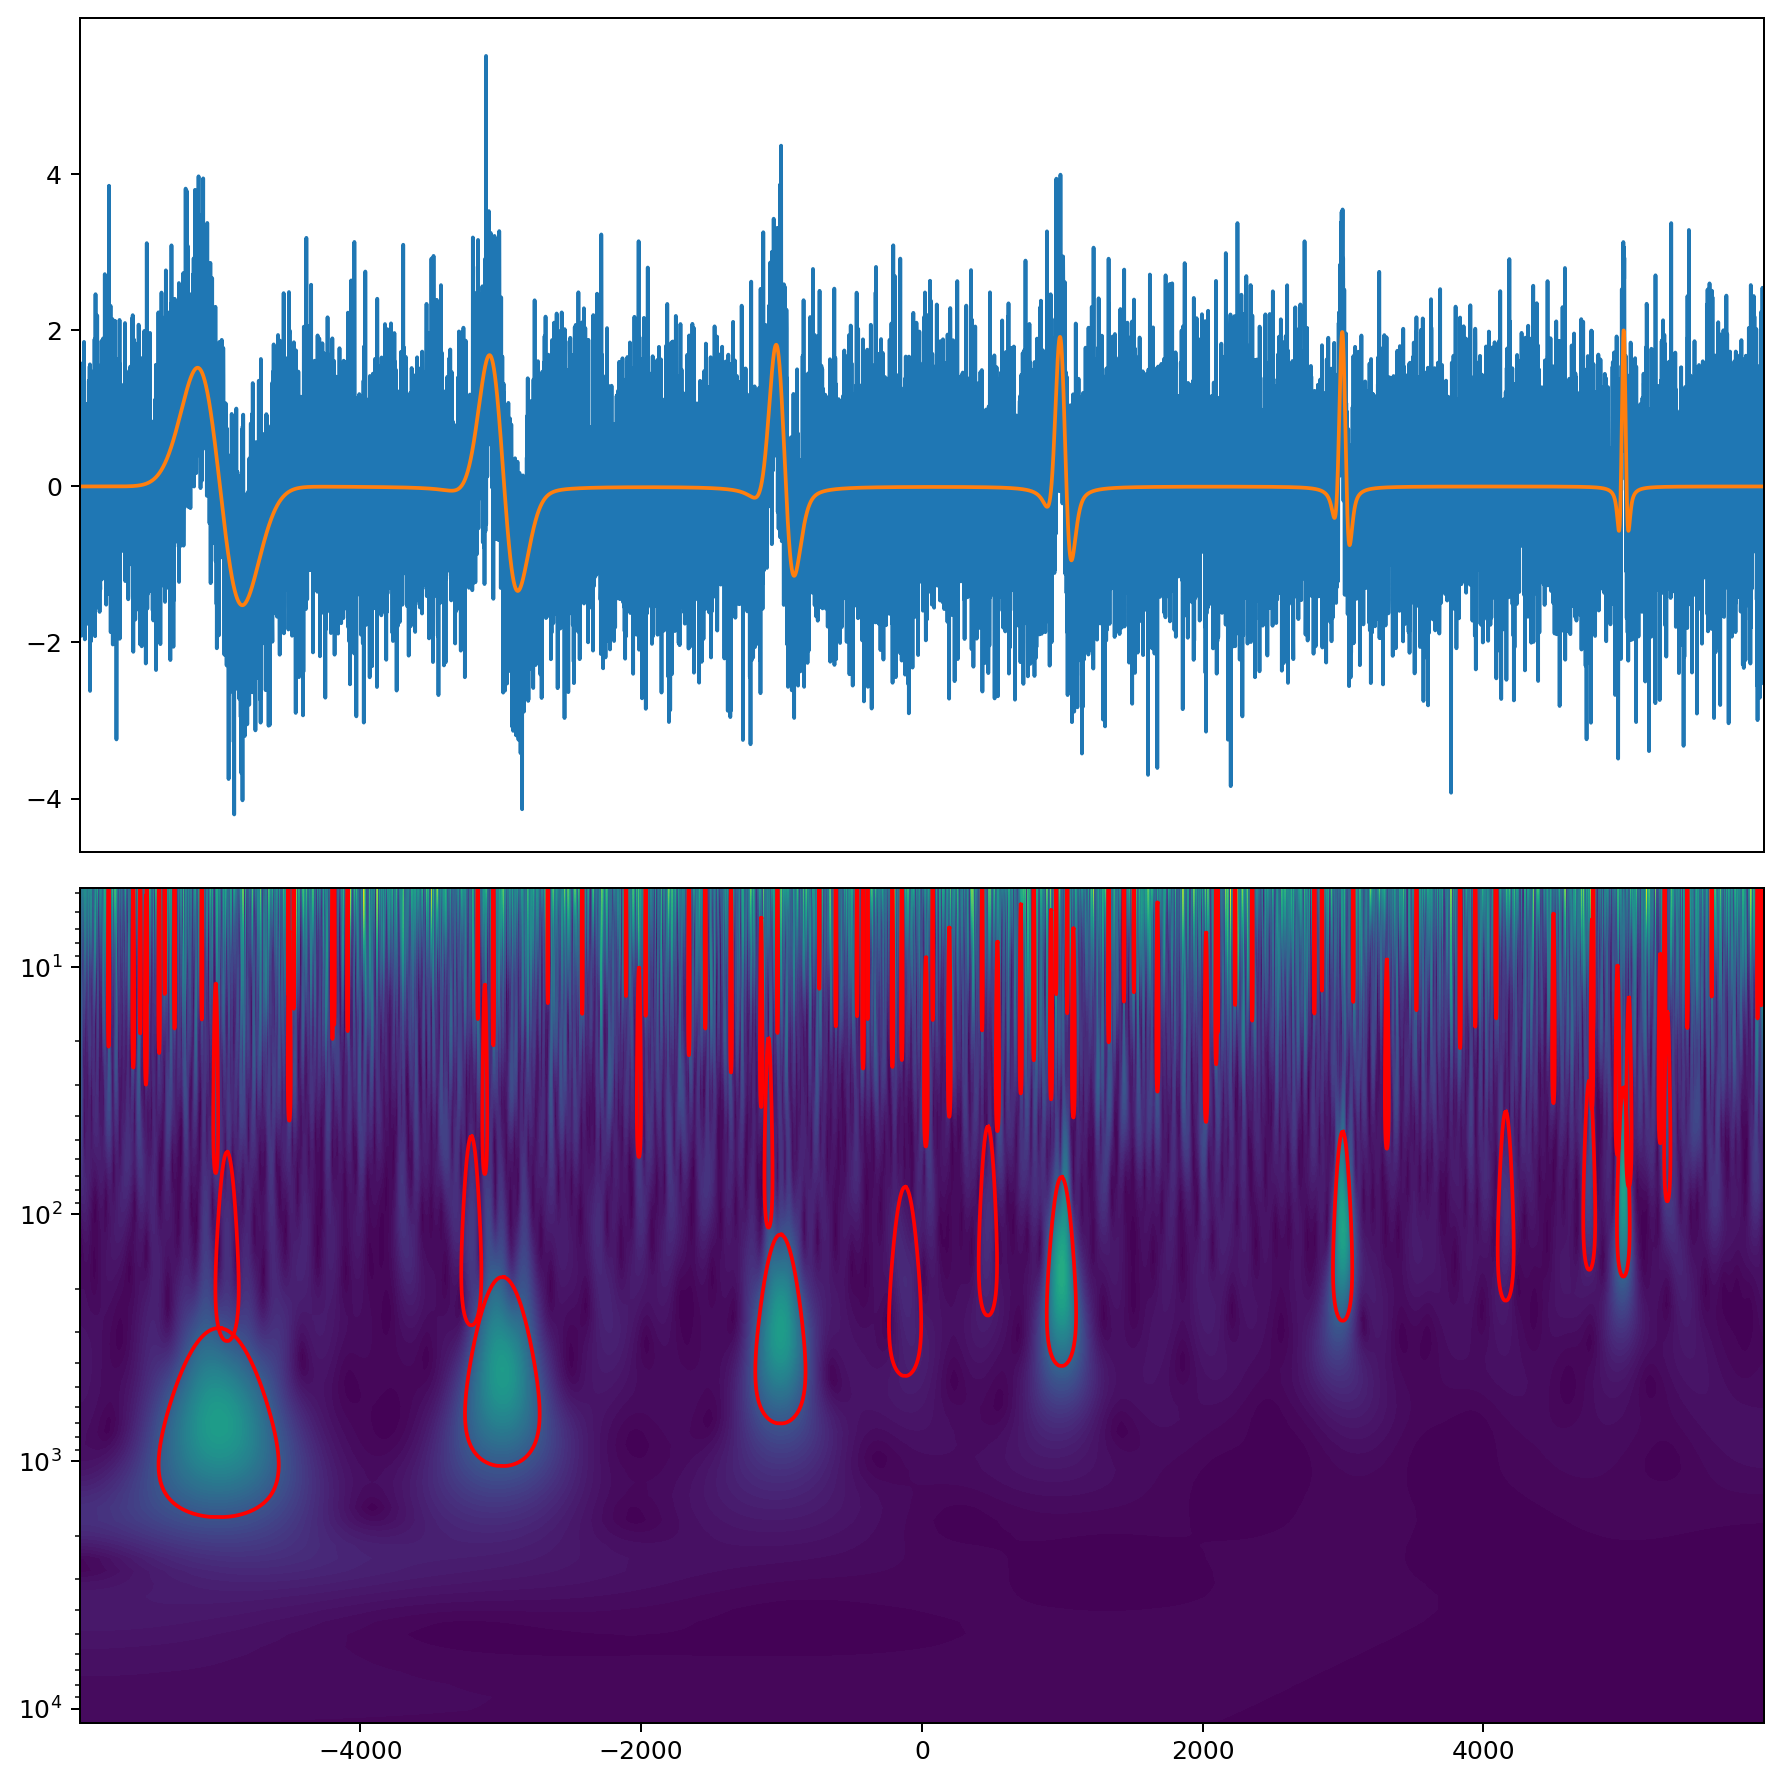

In [3]:
# element analysis - signal plus noise figure
import numpy as np
import warnings
from scipy.signal import detrend
from analytic_wavelet import ElementAnalysisMorse, rotate, make_unpad_slices, analytic_wavelet_transform, \
    maxima_of_transform, wavelet_contourf
%matplotlib inline
from matplotlib import pyplot as plt, gridspec
from matplotlib.patches import Polygon

t = np.arange(12000)
t = t - np.mean(t)
ea_morse = ElementAnalysisMorse(gamma=2, analyzing_beta=2, element_beta=1)
fo = np.logspace(np.log10(2 * np.pi / 100), np.log10(2 * np.pi / 1000), 6)
psi, _ = ea_morse.element_morse.make_wavelet(len(t), fo)
phi = np.linspace(0, np.pi / 2, 6)

for i in range(len(psi)):
    c = 2 * rotate(phi[i]) / np.max(np.abs(psi[i]))
    shift = len(t) // 2 - (1000 + i * 2000)
    psi[i] = np.real(c * np.roll(psi[i], shift, 0))

xo = np.sum(np.real(psi), axis=0)
fs = ea_morse.analyzing_morse.log_spaced_frequencies(
    num_timepoints=len(t), high=np.pi, nyquist_overlap=0.05, endpoint_overlap=3)

np.random.seed(42)

def impulse_analysis(alpha):
    xe = None
    if alpha == 0:
        xe = np.random.randn(len(t))
    elif alpha == 1:
        xe = np.cumsum(np.random.randn(len(t)))
        xe = xe / np.std(xe)
        xe = xe - np.mean(xe)
    elif alpha is None:
        pass
    else:
        raise ValueError('Unknown alpha')
    
    x = xo if xe is None else xo + xe
    
    result = {
        'x': x,
        'xo': xo,
        'xe': xe,
        't': t
    }
    
    pad_width = x.shape[-1]
    unpad_slices = make_unpad_slices(x.ndim, pad_width)
    
    x = np.pad(detrend(x, axis=-1), pad_width, mode='symmetric')
    _, psi_f = ea_morse.analyzing_morse.make_wavelet(x.shape[-1], fs)
    w = analytic_wavelet_transform(x, psi_f, False, unpad_slices)
    indices_maxima, maxima_coefficients, interp_fs = maxima_of_transform(w, fs)
    c_hat, rho_hat, f_hat = ea_morse.event_parameters(maxima_coefficients, interp_fs)
    indicator_isolated, event_influence_regions = ea_morse.isolated_maxima(
        indices_maxima, maxima_coefficients, interp_fs)
    result['w'] = w
    result['indices_maxima'] = indices_maxima
    result['maxima_coefficients'] = maxima_coefficients
    result['interp_fs'] = interp_fs
    result['c_hat'] = c_hat
    result['rho_hat'] = rho_hat
    result['f_hat'] = f_hat
    result['indicator_isolated'] = indicator_isolated
    result['event_influence_regions'] = event_influence_regions
    
    result['wo'] = analytic_wavelet_transform(
        np.pad(detrend(xo, axis=-1), pad_width, mode='symmetric'), psi_f, False, unpad_slices)

    if xe is not None:
        result['we'] = analytic_wavelet_transform(
            np.pad(detrend(xe, axis=-1), pad_width, mode='symmetric'), psi_f, False, unpad_slices)
        
    return result


def reconstruct(analysis, indicator=None):
    psi_hat, _ = ea_morse.element_morse.make_wavelet(len(t), analysis['f_hat'])
    for idx_maxima in range(len(analysis['maxima_coefficients'])):
        psi_hat[idx_maxima] = (
            np.real(analysis['c_hat'][idx_maxima] 
                    * np.roll(psi_hat[i], len(t) // 2 - analysis['indices_maxima'][-1][idx_maxima])) 
            * analysis['rho_hat'][idx_maxima])
    
    psi_hat = np.real(psi_hat)
    
    if indicator is None:
        return np.sum(psi_hat, 0)
    
    return np.sum(psi_hat[indicator], 0)
    

def plot_analysis(analysis):
    x_hat = reconstruct(analysis)
    num_grid_rows = 2
    grid = gridspec.GridSpec(num_grid_rows, 1)
    fig = plt.figure(figsize=(10, num_grid_rows * 5), dpi=180)
    ax1 = fig.add_subplot(grid[0, 0])
    # ax1.plot(t, x_hat)
    ax1.plot(t, xo)
    ax1.set_xticks([])
    ax2 = fig.add_subplot(grid[1, 0])
    wavelet_contourf(ax2, t, 2 * np.pi / fs, analysis['wo'])
    ax2.set_yscale('log')
    ax2.invert_yaxis()
    ax1.set_xlim(ax2.get_xlim())
    fig.tight_layout()
    
    
def plot_analysis_2(analysis, min_w_tilde=None, min_w=None, x_order=('x')):
    indices_maxima = analysis['indices_maxima']
    
    # standard deviation of the coefficients at the highest frequency used as
    # the estimate of the standard deviation of the noise
    sigma = np.std(np.abs(analysis['w'][0]))
    w_tilde = analysis['maxima_coefficients'] / (sigma * np.sqrt(analysis['interp_fs'] / fs[0]))
    all_w_tilde = analysis['w'] / np.expand_dims(sigma * np.sqrt(fs / fs[0]), axis=1)
    
    indicator_sig = analysis['indicator_isolated']
    
    if min_w_tilde is not None:
        indicator_sig = np.logical_and(indicator_sig, np.abs(w_tilde) > min_w_tilde)
    if min_w is not None:
        indicator_sig = np.logical_and(indicator_sig, np.abs(w) > min_w)

    x = {
        'x': analysis['x'],
        'xo': analysis['xo'],
        'x_sig': reconstruct(analysis, indicator_sig),
        'x_iso': reconstruct(analysis, analysis['indicator_isolated'])
    }
    
    num_grid_rows = 2
    grid = gridspec.GridSpec(num_grid_rows, 1)
    fig = plt.figure(figsize=(10, num_grid_rows * 5), dpi=180)
    ax1 = fig.add_subplot(grid[0, 0])
    for key in x_order:
        ax1.plot(t, x[key])
    ax1.set_xticks([])
    ax2 = fig.add_subplot(grid[1, 0])
    wavelet_contourf(ax2, t, 2 * np.pi / fs, analysis['w'], levels=100)
    xlim = ax2.get_xlim()
    ylim = ax2.get_ylim()
    region_coord = analysis['event_influence_regions']
    print(len(indicator_sig), np.count_nonzero(indicator_sig))
    region_coord = region_coord[indicator_sig]
    
    for event_region in region_coord:
        ax2.plot(event_region[1] - (len(t) + 1) / 2, 2 * np.pi / event_region[0], color='red')
    
#     from matplotlib.patches import Polygon
#     indices_sort = np.argsort(-np.abs(analysis['maxima_coefficients']))
#     region_coord = region_coord[indices_sort]
#     sorted_indices_maxima = tuple(ind[indices_sort] for ind in indices_maxima)
#     points = np.concatenate([
#         np.expand_dims(sorted_indices_maxima[-2], 1),
#         np.expand_dims(sorted_indices_maxima[-1], 1)], axis=1)
#     for idx, event_region in enumerate(region_coord):
#         p = Polygon(event_region.T)
#         indicator_contained = p.contains_points(points[:idx])
#         if idx > 107 and np.any(indicator_contained):
#             print(idx)
#             contained = points[:idx][indicator_contained]
#             ax2.scatter(contained[:, 1] - len(t) + 1 / 2, 2 * np.pi / contained[:, 0], color='green')
#             ax2.plot(event_region[1] - (len(t) + 1) / 2, 2 * np.pi / event_region[0], color='red')
#             break
        
    ax2.set_ylim(ylim)
    ax2.set_xlim(xlim)
    ax2.set_yscale('log')
    ax2.invert_yaxis()
    ax1.set_xlim(xlim)
    fig.tight_layout()
    
# with warnings.catch_warnings():
#     warnings.filterwarnings(action='error', category=np.ComplexWarning)
#     clean_analysis = impulse_analysis(None)
#     plot_analysis_2(clean_analysis)

white_analysis = impulse_analysis(0)
plot_analysis_2(white_analysis, min_w_tilde=4, x_order=['x', 'xo']) # , 'x_iso', 'x_sig'])

# red_analysis = impulse_analysis(1)


# % figure, [h,hl]=wavespecplot(t,[xhat xo],2*pi./fs,wo);colormap lansey
# % linestyle -hh hl k: k
# % axes(h(1)),ylabel('Signal Amplitude'),
# % title('Wavelet Transform of Isolated Events')
# % text(-5700,-1.80,'(a)')
# % axes(h(2)),ylabel('Transform Period $2\pi/\omega_s$'),xlabel('Time')
# % plot(t(ii),2*pi./ff,'ws','markerfacecolor',[1 1 1]*0.7,'markersize',6)
# % text(-5700,2.6*10^3,'(b)','color','w'),caxis([0 maxmax(abs(wo))])
# % 
# % [bool,z]=isomax(size(wo),index,ww,ff,ga,be,mu,1/2);
# % plot(interp1([1:length(t)]',t,real(z))+1i*2*pi./imag(z),'color',[1 1 1]*0.7)
# % 
# % orient portrait
# % fontsize 11 11 11 11
# % set(gcf,'paperposition',[1 1 8 5])
# % if strcmpi(str,'print')
# %    %print -djpeg -r1000 impulses-morsetrain-clean.jpg
# %    print -djpeg impulses-morsetrain-clean.jpg
# %    crop('impulses-morsetrain-clean.jpg')
# % end
# %--------------------------------------------------------------------------
# %Transform maxima of a clean signal plus background signals
# use impulses_cleanexample

# %f1=2*pi./10.^[1 1.5 2 2.5 3];
# %f1=2*pi./10.^[1 2 3];
# f1=2*pi./10.^[2 3];
# iieps=[];feps=[];
# for i=1:length(f1)
#     %ii1=round(linspace(1,N,1000*f1(i)/f1(1)))';
#     ii1=round(linspace(1,N,100*f1(i)/f1(1)))';
#     iieps=[iieps;ii1];
#     feps=[feps;f1(i)+0*ii1];
# end
# rhoeps=morsefreq(ga,mu)./feps;

# xeps=zeros(size(x));
# for i=1:length(iieps)
#     psi=morsewave(N,ga,mu,feps(i));
#     psi=2*psi./maxmax(abs(psi))/10;
#     xeps=xeps+real(rot(rand(1)*2*pi)*vshift(psi,N/2-iieps(i),1));
# end

# x=xo+xeps;

# w=wavetrans(x,{ga,be,fs},'mirror');
# [index,ww,ff]=transmax(fs,w);
# [ii,jj]=ind2sub(size(w),index);
# [chat,rhohat,fhat]=maxprops(ww,ff,ga,be,mu);

# figure, [h,hl]=wavespecplot(t,[x xo],2*pi./fs,w);colormap lansey
# linestyle -h hl D U
# axes(h(1)),ylabel('Signal Amplitude'),
# title('Wavelet Transform of Isolated Events Plus Densely Spaced Events')
# %hold on,plot(t,xhat,'w--')
# text(-5700,-1.80,'(a)')
# axes(h(2)),ylabel('Transform Period $2\pi/\omega_s$'),xlabel('Time')
# fact=frac(morsefreq(ga,mu),morsefreq(ga,be)).*frac(be,mu+1).^(1./ga);
# plot(t(iieps),2*pi./(feps/fact),'wo','markersize',4)
# plot(t(ii),2*pi./ff,'.','markeredgecolor',[1 1 1]*0.7)
# plot(t(ii(abs(ww)>1)),2*pi./ff(abs(ww)>1),'ko','markerfacecolor','k')
# %plot(t(ii),2*pi./ff,'ws','markerfacecolor',[1 1 1]*0.7,'markersize',6)
# text(-5700,2.6*10^3,'(b)','color','w'),caxis([0 maxmax(abs(wo))])

# [bool,z]=isomax(size(wo),index,ww,ff,ga,be,mu,1/2);
# plot(interp1([1:length(t)]',t,real(z))+1i*2*pi./imag(z),'color',[1 1 1]*0.7)
# [bool,z]=isomax(size(wo),index(abs(ww)>1),ww(abs(ww)>1),ff(abs(ww)>1),ga,be,mu,1/10);
# plot(interp1([1:length(t)]',t,